In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sys import platform
is_linux = (platform == "linux" or platform == "linux2")

from glob import glob
from os import listdir, mkdir, getcwd, remove
from os.path import isfile, join, basename, isdir

from analysis.split_event_tree import split_event_tree,ttype_column
from analysis.calc import calc_nll_llr_dtf_delta, get_kinematics, filter_for_tf
from analysis.plot_matplotlib import plot_hist
from analysis.fit_funcs import fit_funcs
from analysis.transfer import plot_transfer, plot_transfer_from_df
from analysis.mem import constants

from tqdm.auto import tqdm

/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from analysis.save_data import pd_to_np
from analysis.import_data import import_data,filter_data,combine_columns
import os

if not is_linux:
    mcp = import_data("C:\DevRepositories\comparison\compare_mcparticle_with_mg5.npy")
    reco = import_data("C:\DevRepositories\comparison\compare_reco_with_mg5.npy")
    
else:
    import os; print(os.environ['PATH']); print(os.environ['LD_LIBRARY_PATH'])
    from analysis.cffi.Physsim.CalculateME import lib as physsim
    from analysis.cffi.mg5.lib import calc_zhh, calc_zzh, mc_batch, calc_kinematics_from_int
    
    mcp_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/mcparticle/compare_mcparticle.npy")
    reco_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/reco/compare_reco.npy")

    recalculate = False

    if recalculate:
        #tjmr_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_matchingreco/compare_truejet_matchingreco.npy")
        #tjt_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_true/compare_truejet_true.npy")
        #tjs_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_seen/compare_truejet_seen.npy")

        reco = filter_for_tf(reco_raw)
        mcp = filter_for_tf(mcp_raw, jet=False, lepton=False)
            
        for run_type in ['reco', 'mcparticle']:
            data = mcp if run_type == 'mcparticle' else reco
            
            kinematics = []
            pbar = tqdm(range(len(data)))
            for i in pbar:
                pbar.set_description(f"{run_type}: Getting kinematics for event {i}")
                for value in get_kinematics(data, run_type == 'mcparticle', i): 
                    kinematics.append(value)
                
            mg5_zhh = calc_zhh(kinematics)
            mg5_zzh = calc_zzh(kinematics)

            data["zhh_mg5"] = np.array(mg5_zhh)
            data["zzh_mg5"] = np.array(mg5_zzh)
            data["llr_mg5"] = np.log(data["zhh_mg5"]/data["zzh_mg5"])
            
            # Switch columns (jet,parton)(1,2)_*<->(jet,parton)_(3,4)**,
            rename_map = {}
            for i in range(4):
                for p in ["jet", "parton"]:
                    i_new = ((3+i) if i < 2 else (i-1))
                    for q in ["e", "px", "py", "pz"]:
                        rename_map[f"{p}{i+1}_{q}"] = f"{p}{i_new}_{q}"

            data.rename(columns=rename_map, inplace=True)

            np.save(f"/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/{run_type}/compare_{run_type}_with_mg5.npy", pd_to_np(data))
            
    else:
        mcp  = pd.DataFrame(np.load("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/mcparticle/compare_mcparticle_with_mg5.npy", allow_pickle=True))
        reco = pd.DataFrame(np.load("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/reco/compare_reco_with_mg5.npy", allow_pickle=True))
    
from analysis.plot_routines import plot_llr
from analysis.calc import calc_nll_llr_dtf_delta

mcp = calc_nll_llr_dtf_delta(filter_data(mcp))
reco = calc_nll_llr_dtf_delta(filter_data(reco))

/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/bin:/nfs/dust/ilc/user/bliewert/.vscode-server/bin/abd2f3db4bdb28f9e95536dfa84d8479f1eb312d/bin/remote-cli:/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/bin:/nfs/dust/ilc/user/bliewert/.mambaforge/condabin:/usr/lib/heimdal/bin:/afs/desy.de/common/passwd:/usr/local/bin:/usr/bin:/afs/desy.de/user/b/bliewert/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin
/afs/desy.de/user/b/bliewert/public/ILCSoft/LCIO/lib64:/afs/desy.de/user/b/bliewert/public/ILCSoft/Physsim/lib64:/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/analysis/cffi/mg5/mg5/lib


In [59]:
for run_type in ['reco', 'mcparticle']:
    data = mcp if run_type == 'mcparticle' else reco
    rename_map = {}
    for i in range(4):
        for p in ["jet", "parton"]:
            i_new = ((3+i) if i < 2 else (i-1))
            for q in ["e", "px", "py", "pz"]:
                rename_map[f"{p}{i+1}_{q}"] = f"{p}{i_new}_{q}"

    data.rename(columns=rename_map, inplace=True)

In [60]:
for run_type in ['reco', 'mcparticle']:
    data = mcp if run_type == 'mcparticle' else reco
    
    kinematics = []
    pbar = tqdm(range(len(data)))
    for i in pbar:
        pbar.set_description(f"{run_type}: Getting kinematics for event {i}")
        for value in get_kinematics(data, run_type == 'mcparticle', i): 
            kinematics.append(value)
        
    mg5_zhh = calc_zhh(kinematics)
    mg5_zzh = calc_zzh(kinematics)

    data["zhh_mg5"] = np.array(mg5_zhh)
    data["zzh_mg5"] = np.array(mg5_zzh)
    data["llr_mg5"] = np.log(data["zhh_mg5"]/data["zzh_mg5"])

mcparticle: Getting kinematics for event 30789: 100%|██████████| 30790/30790 [00:19<00:00, 1579.01it/s]


In [61]:
np.count_nonzero(mcp["zhh_mg5"] > mcp["zzh_mg5"])

23740

In [62]:
mcp["llr_mg5"] = np.log(mcp["zhh_mg5"]/mcp["zzh_mg5"])
reco["llr_mg5"] = np.log(reco["zhh_mg5"]/reco["zzh_mg5"])

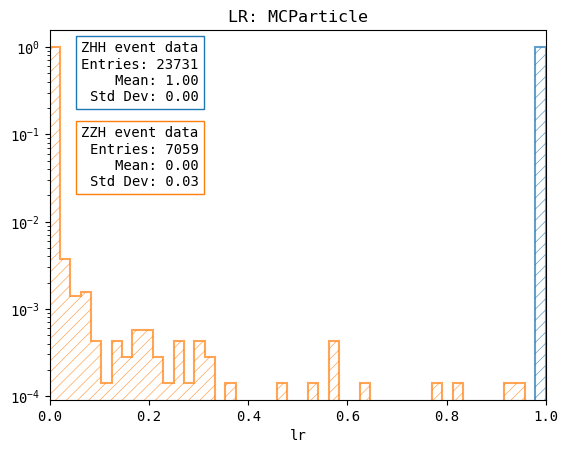

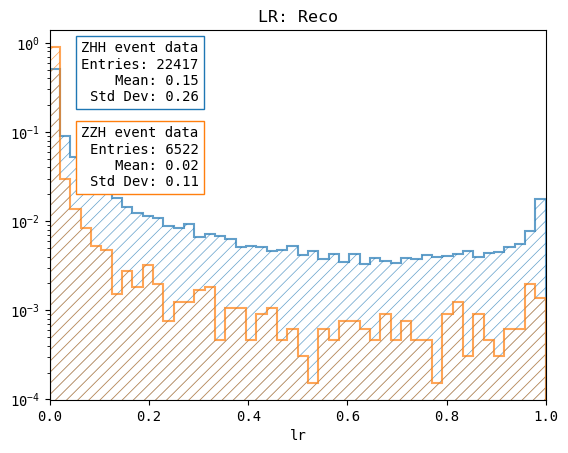

In [63]:
from analysis.import_data import split_true_zhh_zzh

def plot_r(data, name):
    true_zhh, true_zzh = split_true_zhh_zzh(data)

    llr = {
        "zhh_r": true_zhh["r_mg5"],
        "zzh_r": true_zzh["r_mg5"]
    }

    fig, ax = plt.subplots()
    plot_hist(llr, x = ["zhh_r", "zzh_r"], labels=["ZHH event data", "ZZH event data"], title="LR: {}".format(name), text_start_x= 0.3, normalize=True, xlim=(0.0,1.0), xlim_binning=(0,1.1), xlabel="lr", ax=ax, bins=48, yscale="log")

mcp["r_mg5"] = mcp["zhh_mg5"]/(mcp["zhh_mg5"]+mcp["zzh_mg5"])
reco["r_mg5"] = reco["zhh_mg5"]/(reco["zhh_mg5"]+reco["zzh_mg5"])

plot_r(mcp, "MCParticle")
plot_r(reco, "Reco")

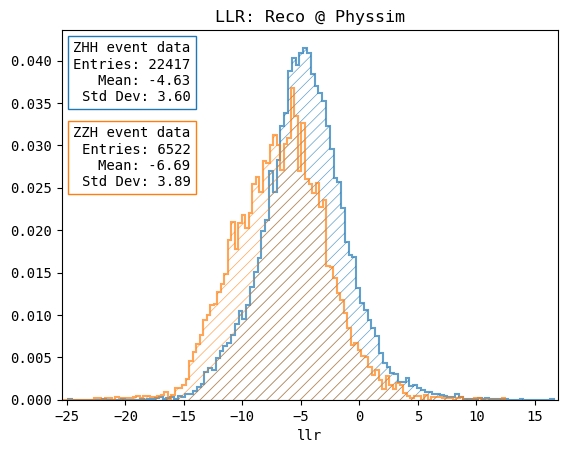

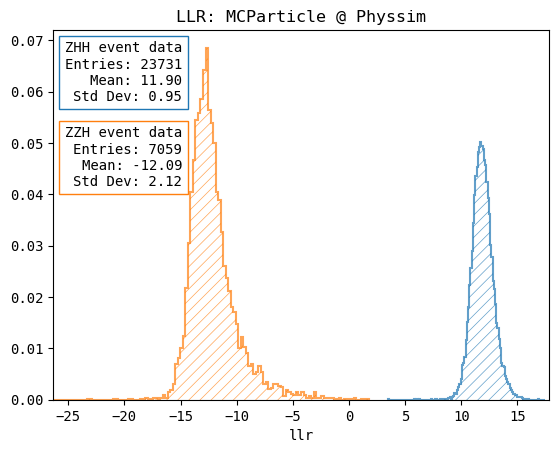

In [32]:
plot_llr(reco, "Reco @ Physsim")
plot_llr(mcp, "MCParticle @ Physsim")

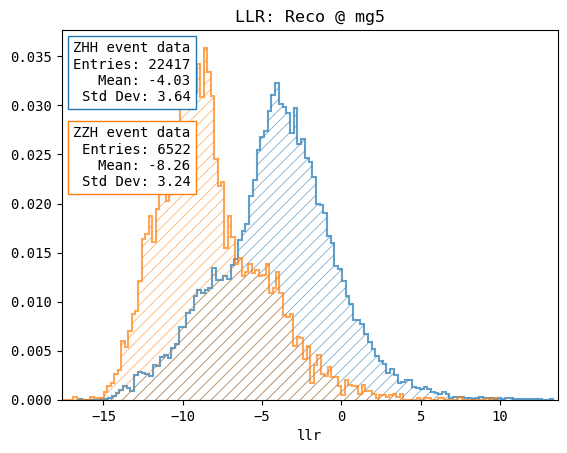

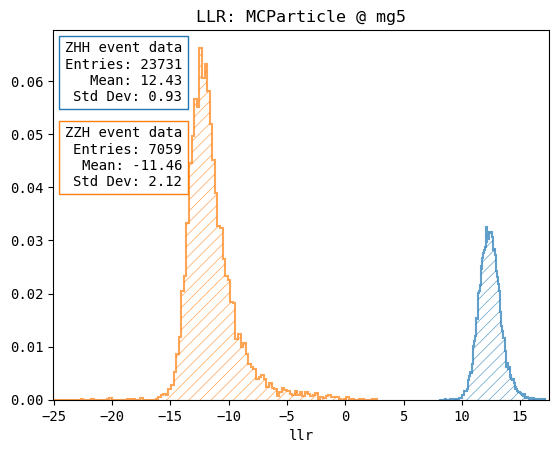

In [33]:
plot_llr(reco, "Reco @ mg5", llr_column='llr_mg5')
plot_llr(mcp, "MCParticle @ mg5", llr_column='llr_mg5')

In [8]:
from analysis.energy_transfer import plot_jet_energy_transfer_from_df, plot_energy_transfer

Jet Transfer (Energy, Angles)

[-0.99692351  6.14668433]
[-1.02718438  6.27770407]
[-1.38580004  6.52747822]
[-1.20268923  6.42380481]


/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/analysis/plot_matplotlib.py:204: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ylim)


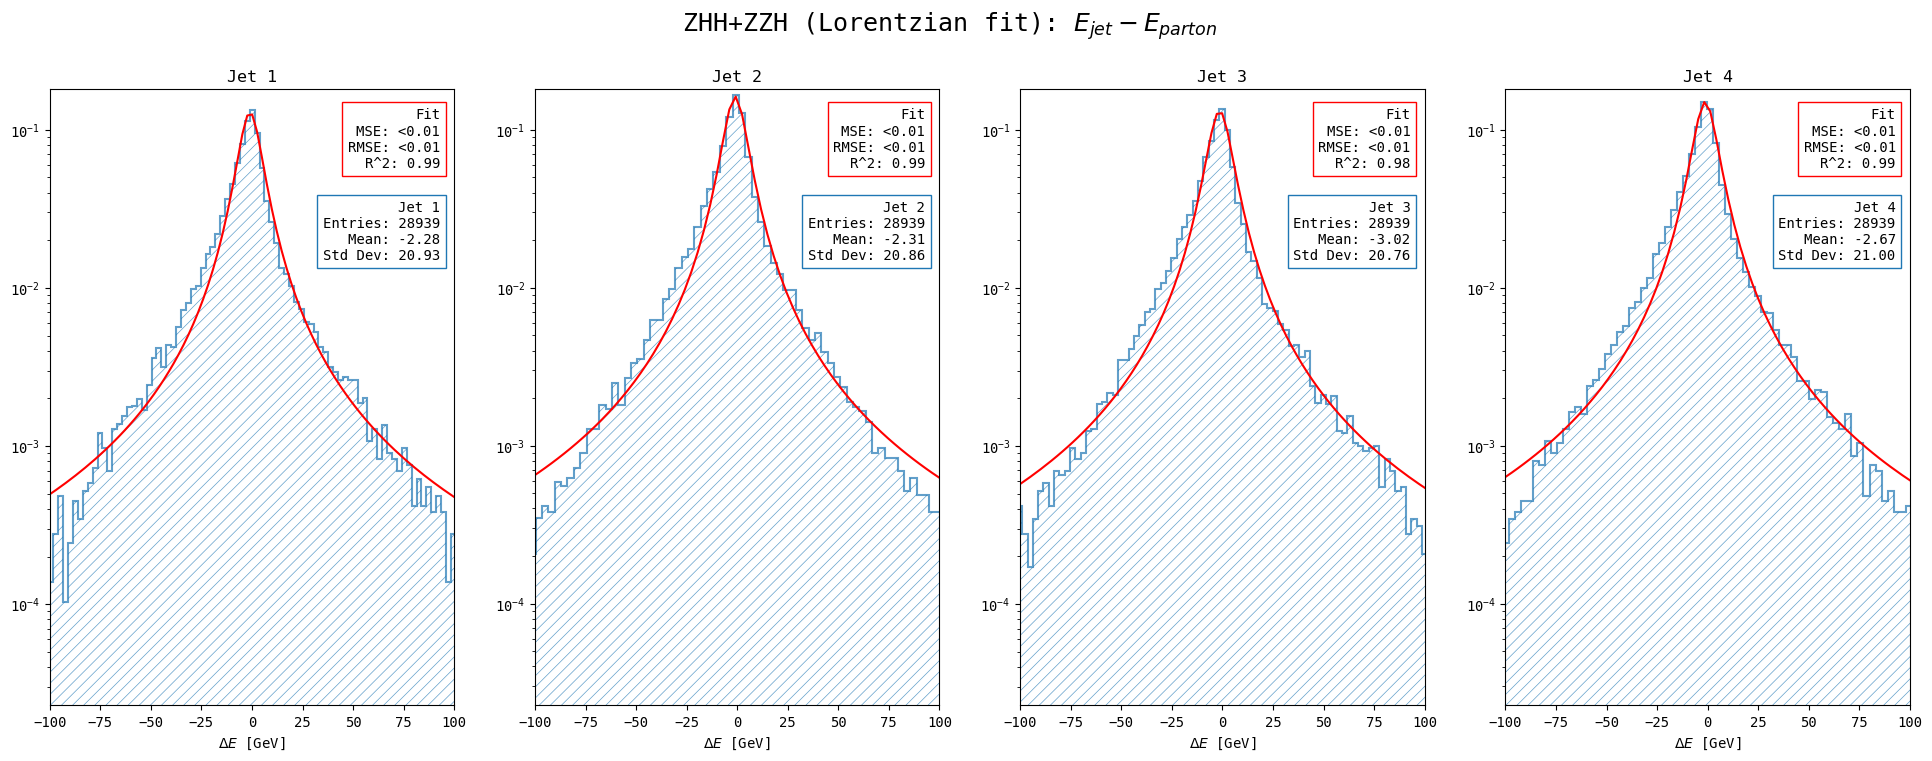

In [9]:
plot_transfer_from_df(reco, "ZHH+ZZH (Lorentzian fit)", fit="lorentz", yscale="log")

[-0.70306152  3.89696966  0.59083129 -4.56093123 17.80342971]
[-0.7306434   4.04608027  0.58132723 -4.65518564 18.45791376]
[-1.04044312  4.37318505  0.59144774 -5.86330006 18.44132398]
[-0.85900886  4.12788927  0.59635451 -5.0760122  18.29031436]


/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/analysis/plot_matplotlib.py:204: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ylim)


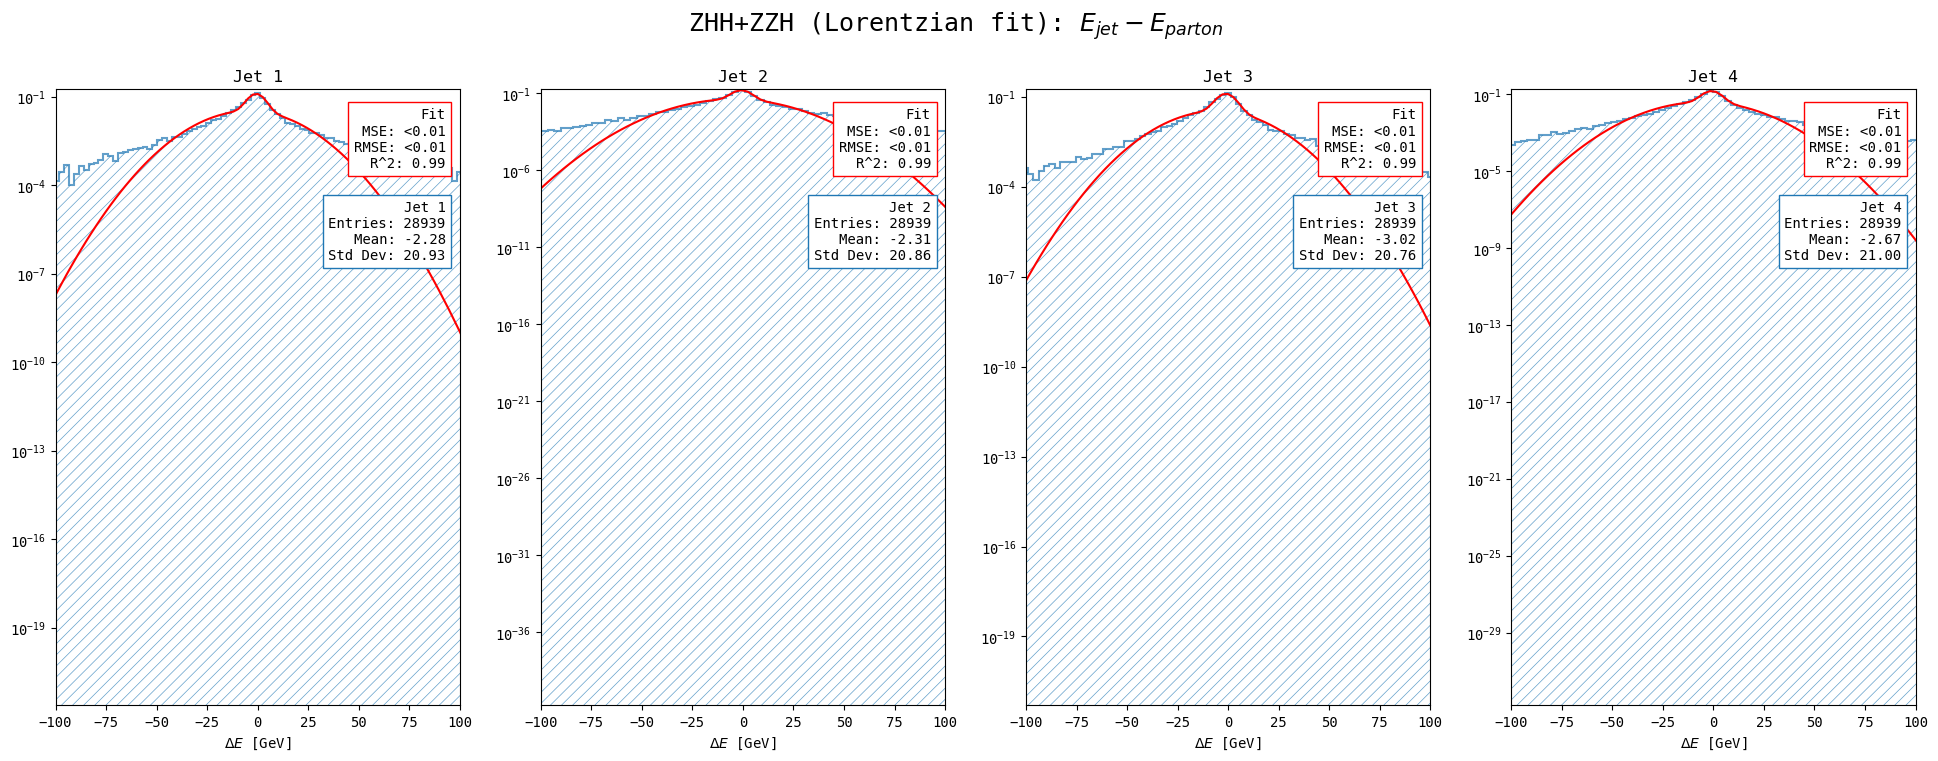

In [70]:
plot_transfer_from_df(reco, "ZHH+ZZH (Lorentzian fit)", fit="dbgauss_old", yscale="log")

In [27]:
# Check normalization of dbgauss
from scipy.integrate import quad

#E_p = np.array([1]*5)
#E_j = np.array([0]*5)
p_test = [1]*9

def dbgauss_construct(E_p, E_j):
    def dbgauss(a1, a2, a4, a5, b1, b2, b3, b4, b5):
        p1 = a1 + E_p*b1
        p2 = a2 + E_p*b2
        p3 =      E_p*b3
        p4 = a4 + E_p*b4
        p5 = a5 + E_p*b5
        
        return (1/(sqrt(2*pi)*(p2+p3*p5)))*(np.exp(-((E_j-E_p)-p1)**2/(2*p2**2)) + p3*np.exp(-((E_j-E_p) - p4)**2/(2*p5**2)))
    
    return dbgauss

def dbgauss_test(E_p):
    return dbgauss_construct(E_p, 3000)(*p_test)

#dbgauss_test(1)
quad(dbgauss_test, -500000, 500000)

(0.6386920728227685, 1.075138596520517e-09)

In [ ]:
"lorentz": lambda x, x0, gamma:
                     1/(pi*gamma*(1 + ( (x-x0)/gamma )**2 ))

In [37]:
# Check normalization of lorentz
from scipy.integrate import quad

def lorentz(x, x0, gamma):
    #return G/((2*pi)*((x-x0)**2 + ((G**2)/4)))
    return 1/(pi*gamma*(1 + ( (x-x0)/gamma )**2 ))

def lorentz_fit(x):
    popt = [-1.33850763,  6.35057887]
    return bw(x, *popt)

quad(lorentz_fit, -500000, 500000)

(0.9999919141918524, 8.87321588513478e-09)

[-1.33850763  6.35057887]
[-1.36678223  6.4788703 ]
[-1.42685018  6.48213426]
[-1.20858859  6.40604084]


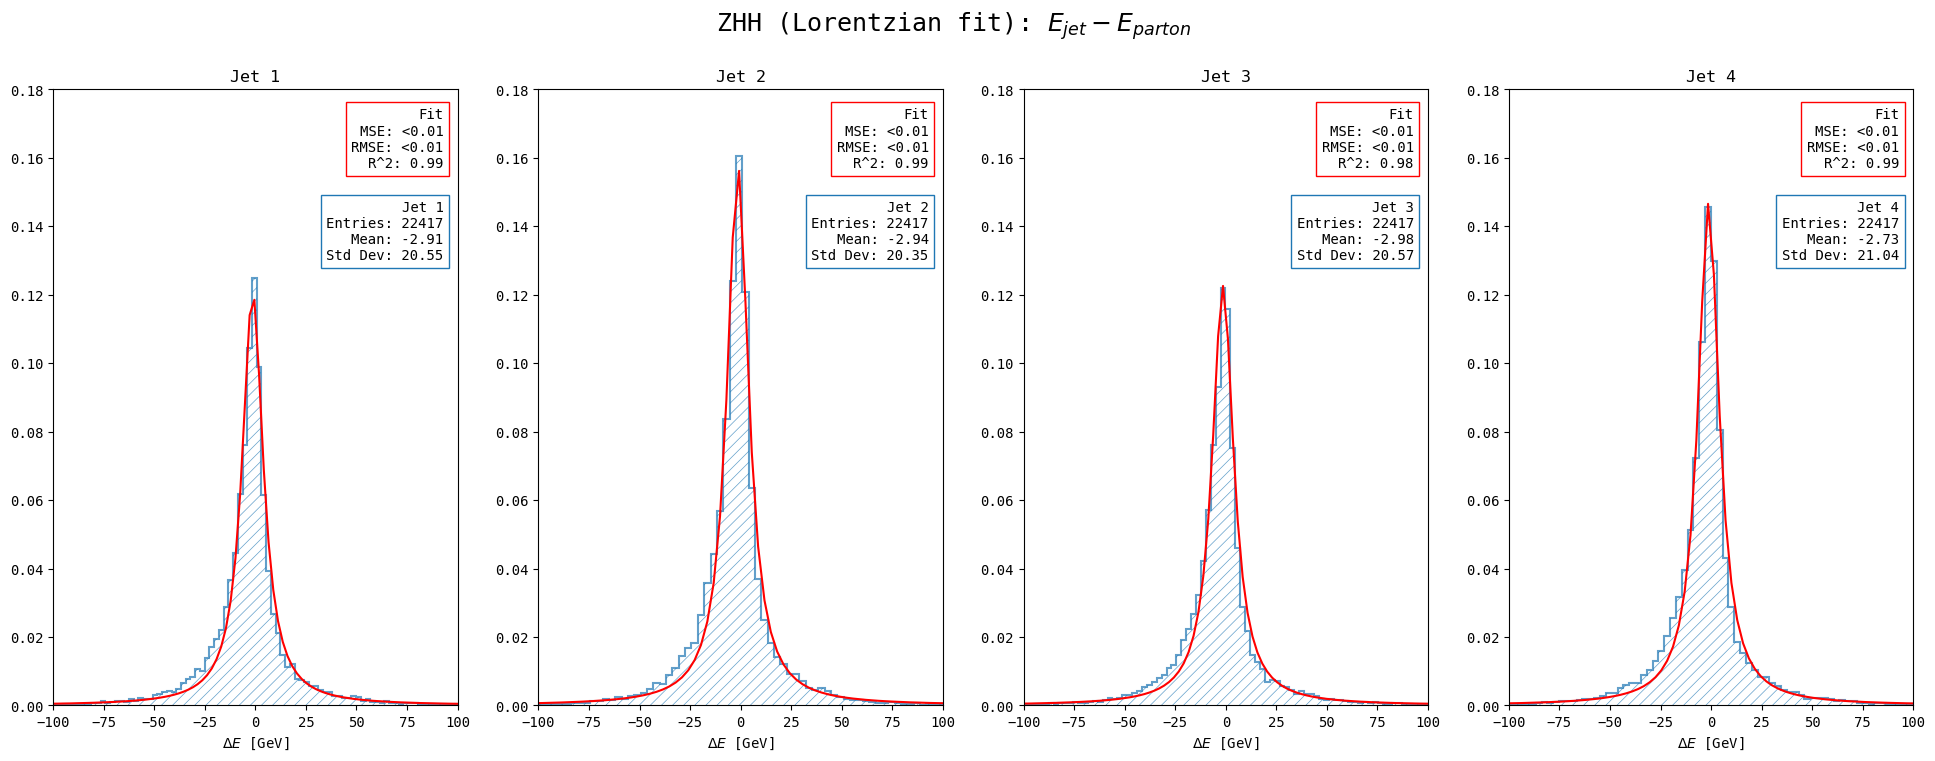

In [7]:
plot_transfer_from_df(reco[reco["is_zhh"] == 1], "ZHH (Lorentzian fit)", fit="lorentz")

[-0.21426421  5.4111742 ]
[-0.07810281  5.41453075]
[-1.3032832   6.58035589]
[-1.23814498  6.50253684]


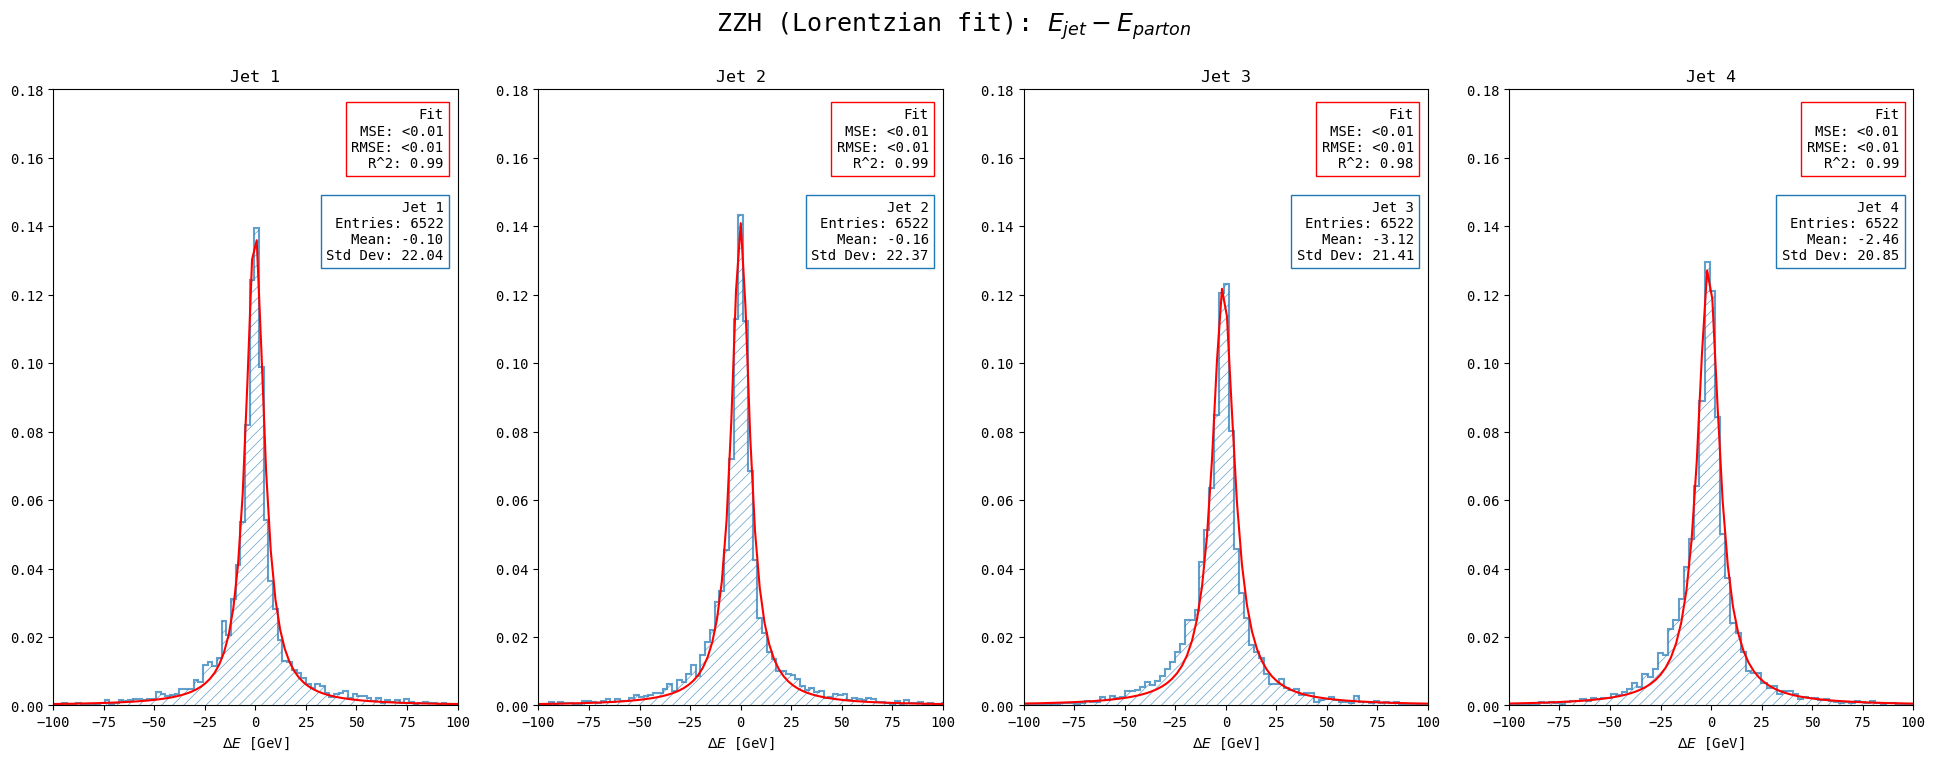

In [8]:
plot_transfer_from_df(reco[reco["is_zzh"] == 1], "ZZH (Lorentzian fit)", fit="lorentz")

pT

[-2.02830254  4.35893197]
[-2.02413195  4.53581626]
[-2.34425106  4.72286748]
[-2.24864263  4.60622201]


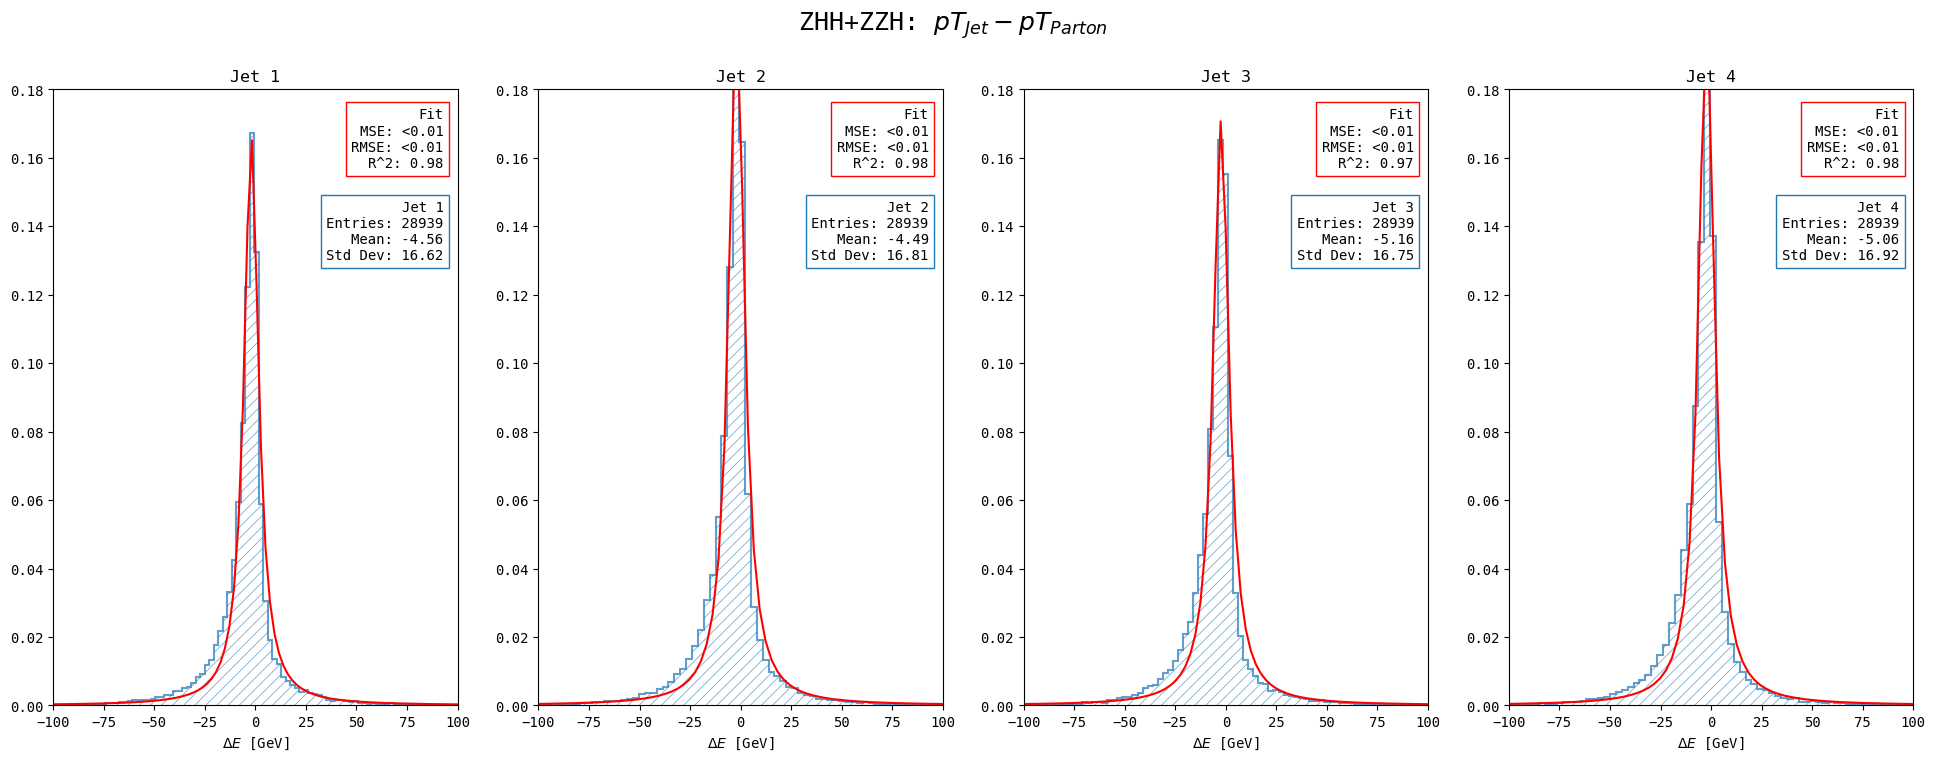

In [62]:
df = []
for i in range(1, 5):
    df.append((
        np.sqrt(reco["jet{}_px".format(i)]**2 + reco["jet{}_py".format(i)] ** 2),
        np.sqrt(reco["parton{}_px".format(i)]**2 + reco["parton{}_py".format(i)] ** 2)
    ))

plot_transfer(df, name="ZHH+ZZH", fit="lorentz", true_label="Parton", reco_label="Jet", quantity="pT")

### Combined transfer functions: Jet energy, theta and phi

[-3.90805346e-05  1.96662844e-02]
[0.0001748  0.02819419]


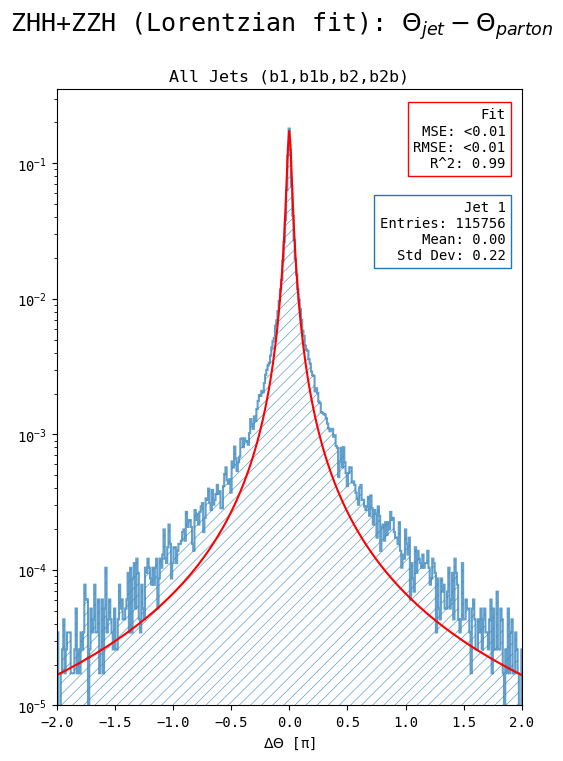

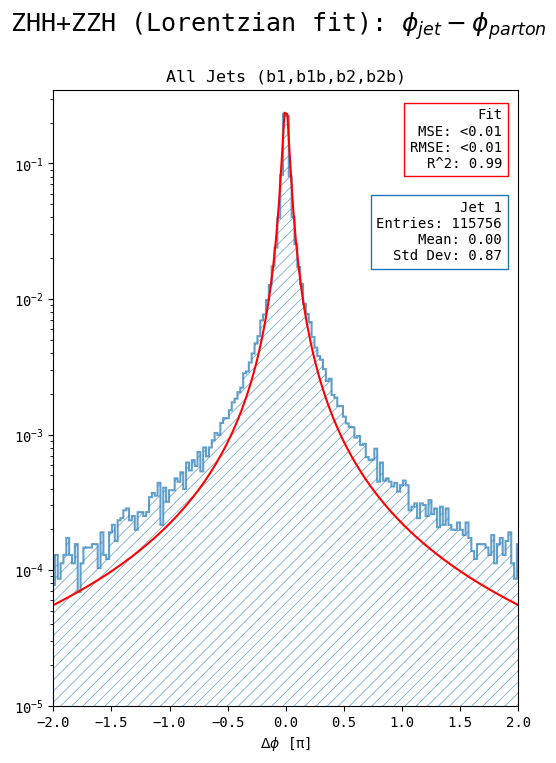

In [23]:
data = reco
df = []

for i in range(1, 5):
    theta = {}
    phi = {}
    for ptype in ["jet", "parton"]:
        theta[ptype] = np.arccos(data[f"{ptype}{i}_pz"] / np.sqrt(data[f"{ptype}{i}_px"]**2 + data[f"{ptype}{i}_py"]**2 + data[f"{ptype}{i}_pz"]**2))
        phi[ptype] = np.arctan2(data[f"{ptype}{i}_py"], data[f"{ptype}{i}_px"])
    
    #theta = acos(z/sqrt(x**2 + y**2 + z**2))
    #phi = atan2(y, x)
    
    df.append((theta, phi))

dg = [[np.array([]), np.array([])]]
for i in range(4):
    dg[0][0] = np.append(dg[0][0], df[i][0]["jet"])
    dg[0][1] = np.append(dg[0][1], df[i][0]["parton"])

plot_transfer(dg, "ZHH+ZZH (Lorentzian fit)", fit="lorentz", quantity="\Theta", xlabel=r"$\Delta\Theta$ [π]", xlim=(-2,2), ylim=(0.00001,0.35), n_bins=512, yscale="log", single_title="All Jets (b1,b1b,b2,b2b)")

dg = [[np.array([]), np.array([])]]
for i in range(4):
    dg[0][0] = np.append(dg[0][0], df[i][1]["jet"])
    dg[0][1] = np.append(dg[0][1], df[i][1]["parton"])

plot_transfer(dg, "ZHH+ZZH (Lorentzian fit)", fit="lorentz", quantity="\phi", xlabel=r"$\Delta\phi$ [π]", xlim=(-2,2), ylim=(0.00001,0.35), n_bins=512, yscale="log", single_title="All Jets (b1,b1b,b2,b2b)")

[-4.03399692e-05  1.96212741e-02]
[0.00039051 0.02811957]


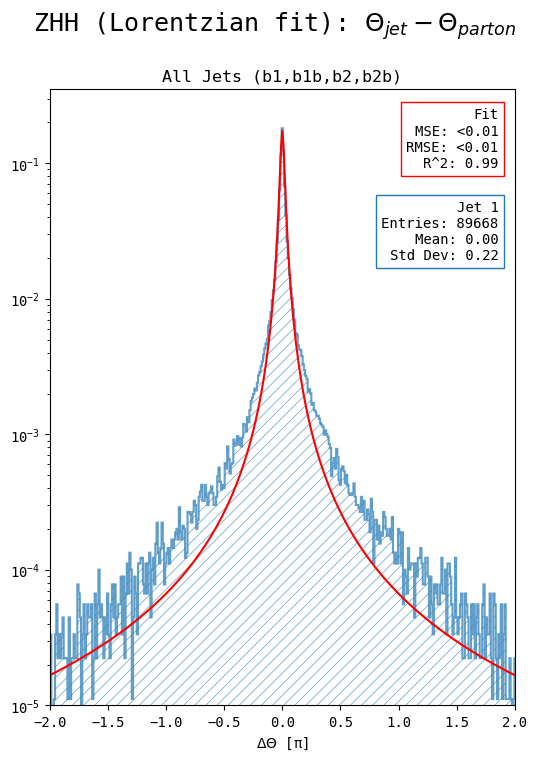

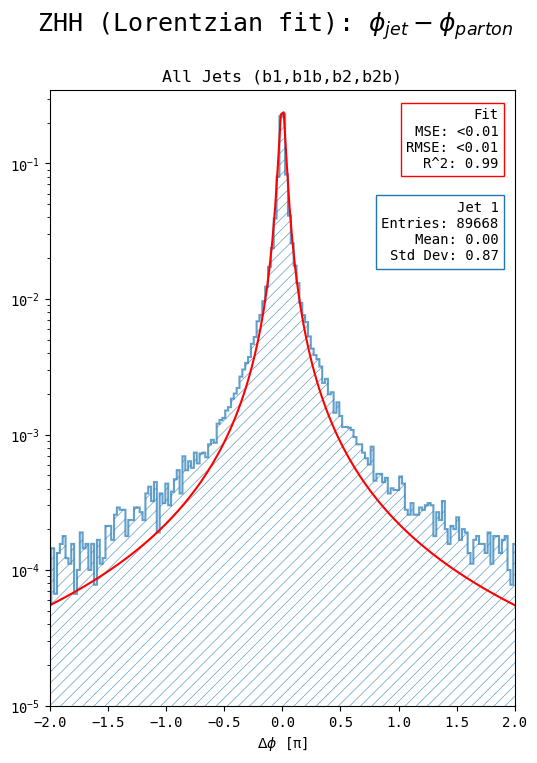

In [25]:
data = reco[reco["is_zhh"] == True]
df = []

for i in range(1, 5):
    theta = {}
    phi = {}
    for ptype in ["jet", "parton"]:
        theta[ptype] = np.arccos(data[f"{ptype}{i}_pz"] / np.sqrt(data[f"{ptype}{i}_px"]**2 + data[f"{ptype}{i}_py"]**2 + data[f"{ptype}{i}_pz"]**2))
        phi[ptype] = np.arctan2(data[f"{ptype}{i}_py"], data[f"{ptype}{i}_px"])
    
    #theta = acos(z/sqrt(x**2 + y**2 + z**2))
    #phi = atan2(y, x)
    
    df.append((theta, phi))

dg = [[np.array([]), np.array([])]]
for i in range(4):
    dg[0][0] = np.append(dg[0][0], df[i][0]["jet"])
    dg[0][1] = np.append(dg[0][1], df[i][0]["parton"])

plot_transfer(dg, "ZHH (Lorentzian fit)", fit="lorentz", quantity="\Theta", xlabel=r"$\Delta\Theta$ [π]", xlim=(-2,2), ylim=(0.00001,0.35), n_bins=512, yscale="log", single_title="All Jets (b1,b1b,b2,b2b)")

dg = [[np.array([]), np.array([])]]
for i in range(4):
    dg[0][0] = np.append(dg[0][0], df[i][1]["jet"])
    dg[0][1] = np.append(dg[0][1], df[i][1]["parton"])

plot_transfer(dg, "ZHH (Lorentzian fit)", fit="lorentz", quantity="\phi", xlabel=r"$\Delta\phi$ [π]", xlim=(-2,2), ylim=(0.00001,0.35), n_bins=512, yscale="log", single_title="All Jets (b1,b1b,b2,b2b)")

[-6.19007451e-06  1.97328833e-02]
[5.19239786e-05 2.83442591e-02]


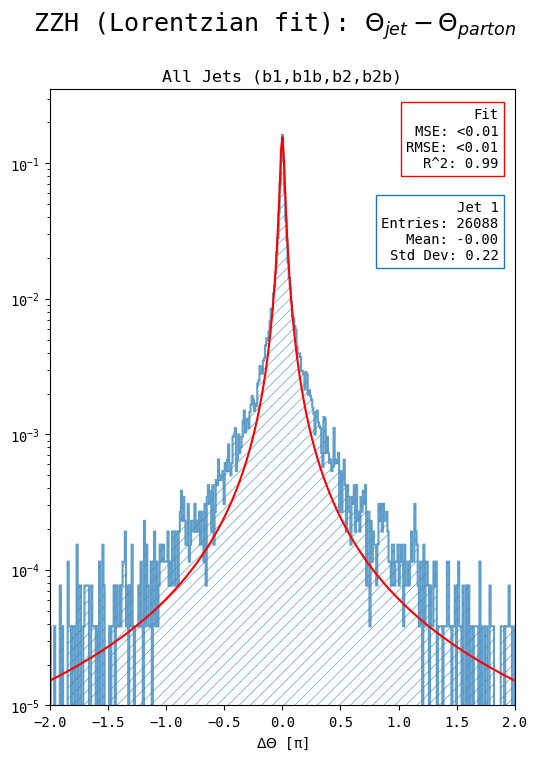

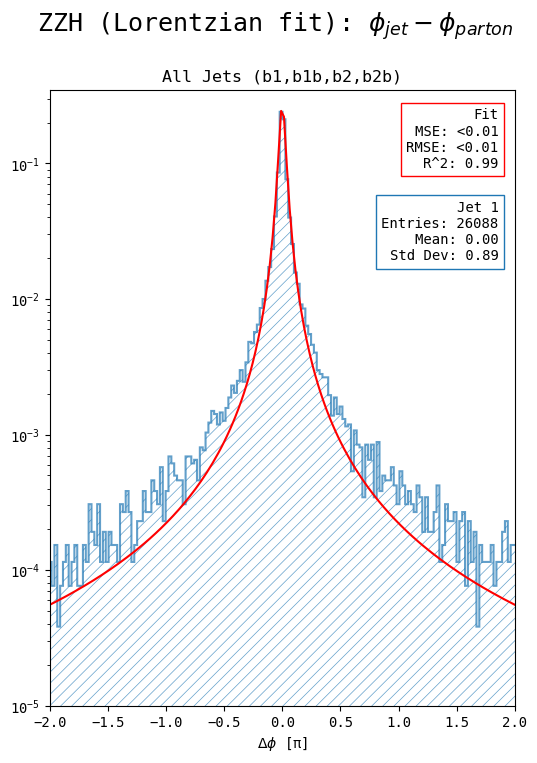

In [27]:
data = reco[reco["is_zzh"] == True]
df = []

for i in range(1, 5):
    theta = {}
    phi = {}
    for ptype in ["jet", "parton"]:
        theta[ptype] = np.arccos(data[f"{ptype}{i}_pz"] / np.sqrt(data[f"{ptype}{i}_px"]**2 + data[f"{ptype}{i}_py"]**2 + data[f"{ptype}{i}_pz"]**2))
        phi[ptype] = np.arctan2(data[f"{ptype}{i}_py"], data[f"{ptype}{i}_px"])
    
    #theta = acos(z/sqrt(x**2 + y**2 + z**2))
    #phi = atan2(y, x)
    
    df.append((theta, phi))

dg = [[np.array([]), np.array([])]]
for i in range(4):
    dg[0][0] = np.append(dg[0][0], df[i][0]["jet"])
    dg[0][1] = np.append(dg[0][1], df[i][0]["parton"])

plot_transfer(dg, "ZZH (Lorentzian fit)", fit="lorentz", quantity="\Theta", xlabel=r"$\Delta\Theta$ [π]", xlim=(-2,2), ylim=(0.00001,0.35), n_bins=512, yscale="log", single_title="All Jets (b1,b1b,b2,b2b)")

dg = [[np.array([]), np.array([])]]
for i in range(4):
    dg[0][0] = np.append(dg[0][0], df[i][1]["jet"])
    dg[0][1] = np.append(dg[0][1], df[i][1]["parton"])

plot_transfer(dg, "ZZH (Lorentzian fit)", fit="lorentz", quantity="\phi", xlabel=r"$\Delta\phi$ [π]", xlim=(-2,2), ylim=(0.00001,0.35), n_bins=512, yscale="log", single_title="All Jets (b1,b1b,b2,b2b)")

[-1.12594285  6.24937028]


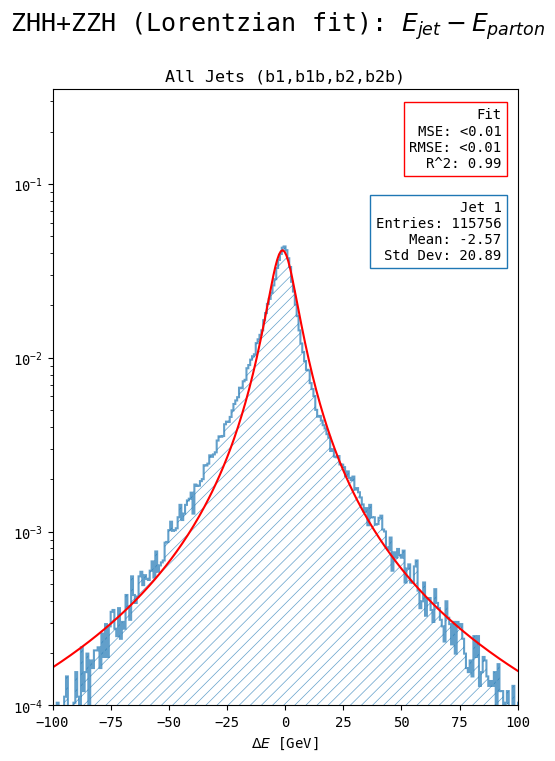

In [16]:
data = reco
dg = [[np.array([]), np.array([])]]
for i in range(4):
    dg[0][0] = np.append(dg[0][0], data[f"jet{i+1}_e"])
    dg[0][1] = np.append(dg[0][1], data[f"parton{i+1}_e"])

plot_transfer(dg, "ZHH+ZZH (Lorentzian fit)", fit="lorentz", quantity="E", xlabel=r"$\Delta E$ [GeV]", xlim=(-100,100), ylim=(0.0001,0.35), n_bins=512, yscale="log", single_title="All Jets (b1,b1b,b2,b2b)")

[-1.29695176  6.34412724]


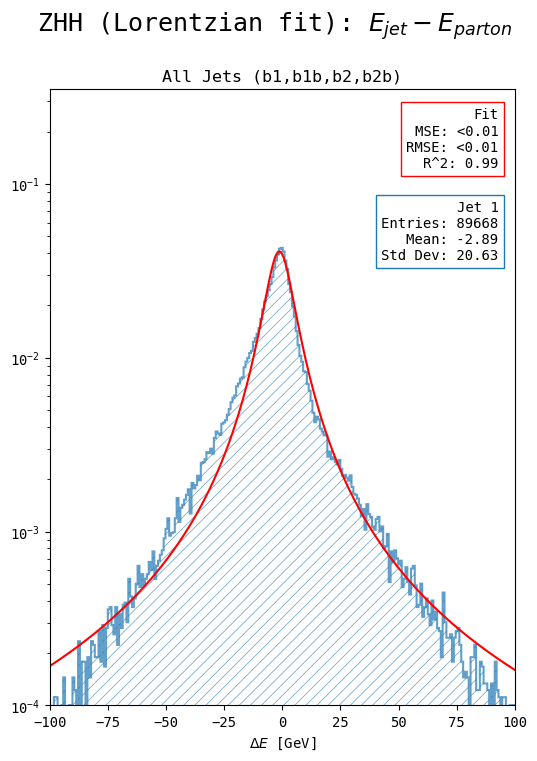

In [22]:
data = reco[reco["is_zhh"] == True]
dg = [[np.array([]), np.array([])]]
for i in range(4):
    dg[0][0] = np.append(dg[0][0], data[f"jet{i+1}_e"])
    dg[0][1] = np.append(dg[0][1], data[f"parton{i+1}_e"])

plot_transfer(dg, "ZHH (Lorentzian fit)", fit="lorentz", quantity="E", xlabel=r"$\Delta E$ [GeV]", xlim=(-100,100), ylim=(0.0001,0.35), n_bins=512, yscale="log", single_title="All Jets (b1,b1b,b2,b2b)")

[-0.60700026  5.89539517]


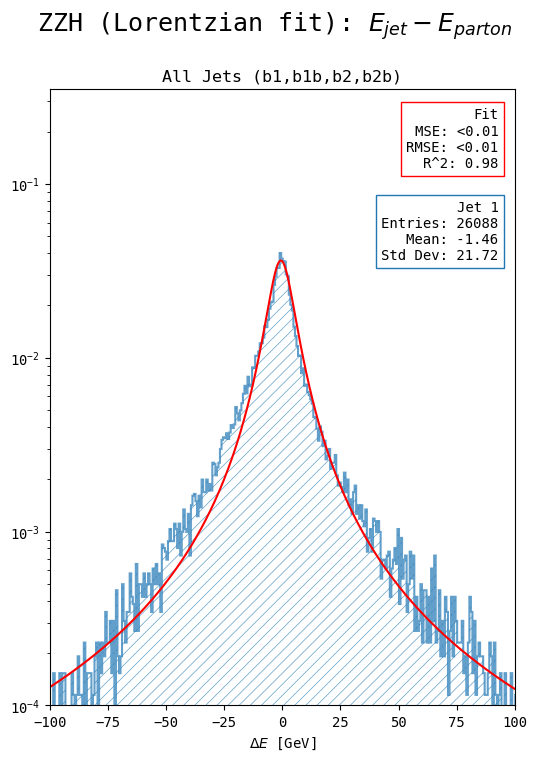

In [20]:
data = reco[reco["is_zzh"] == True]
dg = [[np.array([]), np.array([])]]
for i in range(4):
    dg[0][0] = np.append(dg[0][0], data[f"jet{i+1}_e"])
    dg[0][1] = np.append(dg[0][1], data[f"parton{i+1}_e"])

plot_transfer(dg, "ZZH (Lorentzian fit)", fit="lorentz", quantity="E", xlabel=r"$\Delta E$ [GeV]", xlim=(-100,100), ylim=(0.0001,0.35), n_bins=512, yscale="log", single_title="All Jets (b1,b1b,b2,b2b)")

Muon energies + angles

[-0.26770978  1.20645817  0.16674091 -1.60947224 68.54257242]
[-0.40294954  1.1472375   0.16299994 -0.56050295 68.41215147]


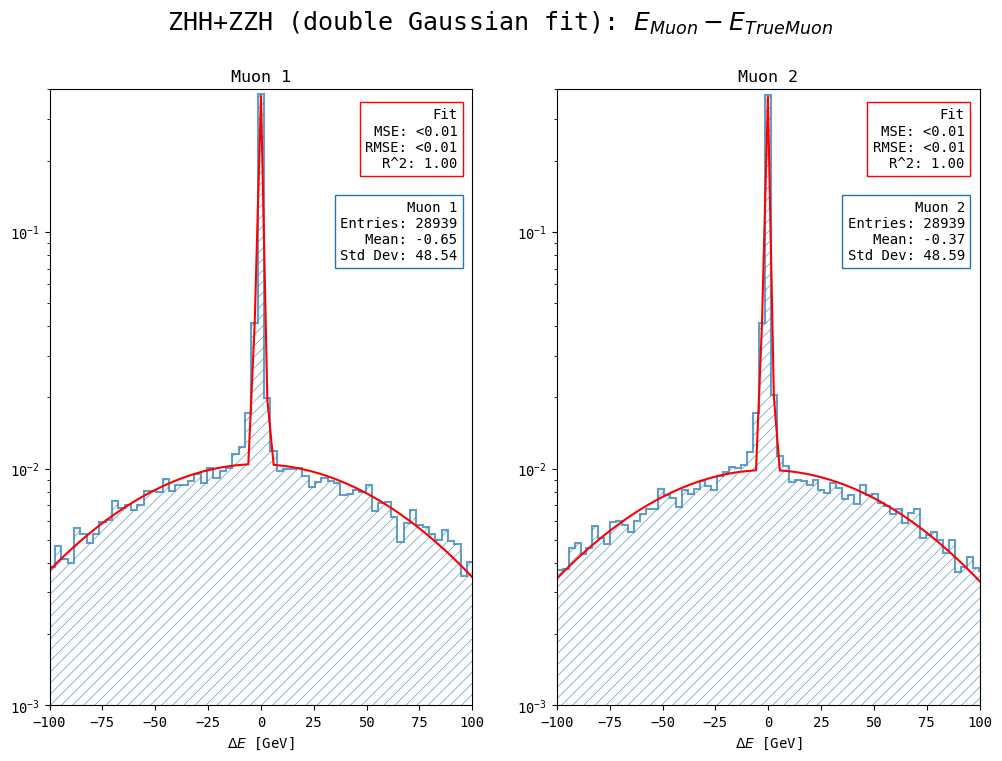

In [72]:
df = []
fit_init = []
for i in range(1, 3):
    df.append((reco[f"lep{i}_e"], reco[f"true_lep{i}_e"]))
    std_dev = np.std(reco[f"lep{i}_e"] - reco[f"true_lep{i}_e"])
    fit_init.append([0, 10, 0.1, 0, 100])    

plot_transfer(df, "ZHH+ZZH (double Gaussian fit)", fit="dbgauss_old", true_label="True Muon", reco_label="Muon", fit_init=fit_init, ylim=(0.001, 0.4), yscale="log")

In [51]:
data = reco

df = []
fit_init = []
for i in range(1, 3):
    theta = {}
    phi = {}
    for ptype in ["lep", "true_lep"]:
        theta[ptype] = np.arccos(data[f"{ptype}{i}_pz"] / np.sqrt(data[f"{ptype}{i}_px"]**2 + data[f"{ptype}{i}_py"]**2 + data[f"{ptype}{i}_pz"]**2))
        phi[ptype] = np.arctan2(data[f"{ptype}{i}_py"], data[f"{ptype}{i}_px"])
    
    df.append((theta, phi))

[-0.00480873  0.00601118  0.11682099  0.89792632  0.61774417]
[ 0.00463754  0.00588112  0.11572021 -0.8967395   0.61939501]


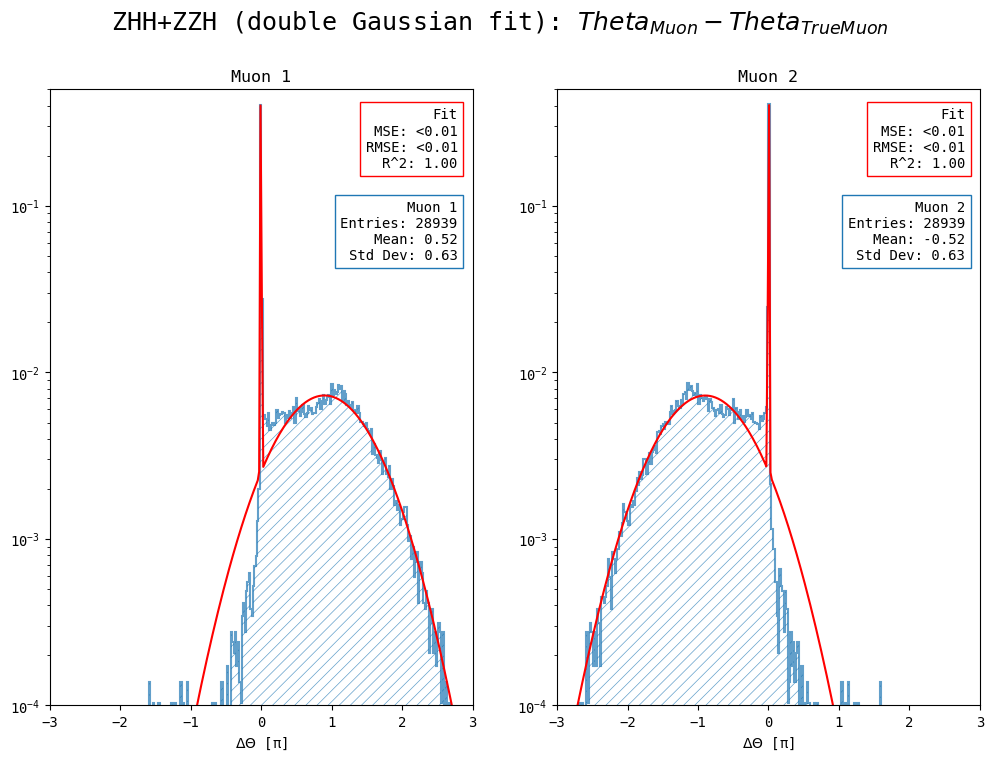

In [110]:
dg = []
fit_init = []
for i in range(2):
    dg.append((df[i][0]["lep"], df[i][0]["true_lep"]))
    fit_init.append([0, 0.1, 0.08, 0, 0.8])

plot_transfer(dg, "ZHH+ZZH (double Gaussian fit)", fit="dbgauss_old", quantity="Theta", xlabel=r"$\Delta\Theta$ [π]", true_label="True Muon", reco_label="Muon", fit_init=fit_init, xlim=(-3,3), ylim=(0.0001, 0.5), n_bins=256, yscale="log")

Jet Angular Transfer

Theta

In [4]:
data = reco

In [5]:
df = []

for i in range(1, 5):
    theta = {}
    phi = {}
    for ptype in ["jet", "parton"]:
        theta[ptype] = np.arccos(data[f"{ptype}{i}_pz"] / np.sqrt(data[f"{ptype}{i}_px"]**2 + data[f"{ptype}{i}_py"]**2 + data[f"{ptype}{i}_pz"]**2))
        phi[ptype] = np.arctan2(data[f"{ptype}{i}_py"], data[f"{ptype}{i}_px"])
    
    #theta = acos(z/sqrt(x**2 + y**2 + z**2))
    #phi = atan2(y, x)
    
    df.append((theta, phi))

Theta

[-1.38006290e-04  1.29029763e-02  4.21039384e-01  9.22202237e-04
  8.71097249e-02]
[-5.40071642e-05  1.31382925e-02  4.23296947e-01 -1.21410360e-03
  8.79496938e-02]
[ 4.78918940e-05  1.28423981e-02  4.36988569e-01 -3.57260891e-04
  8.45886315e-02]
[-9.07817865e-05  1.31156982e-02  4.23715660e-01  3.87447838e-04
  8.81337950e-02]


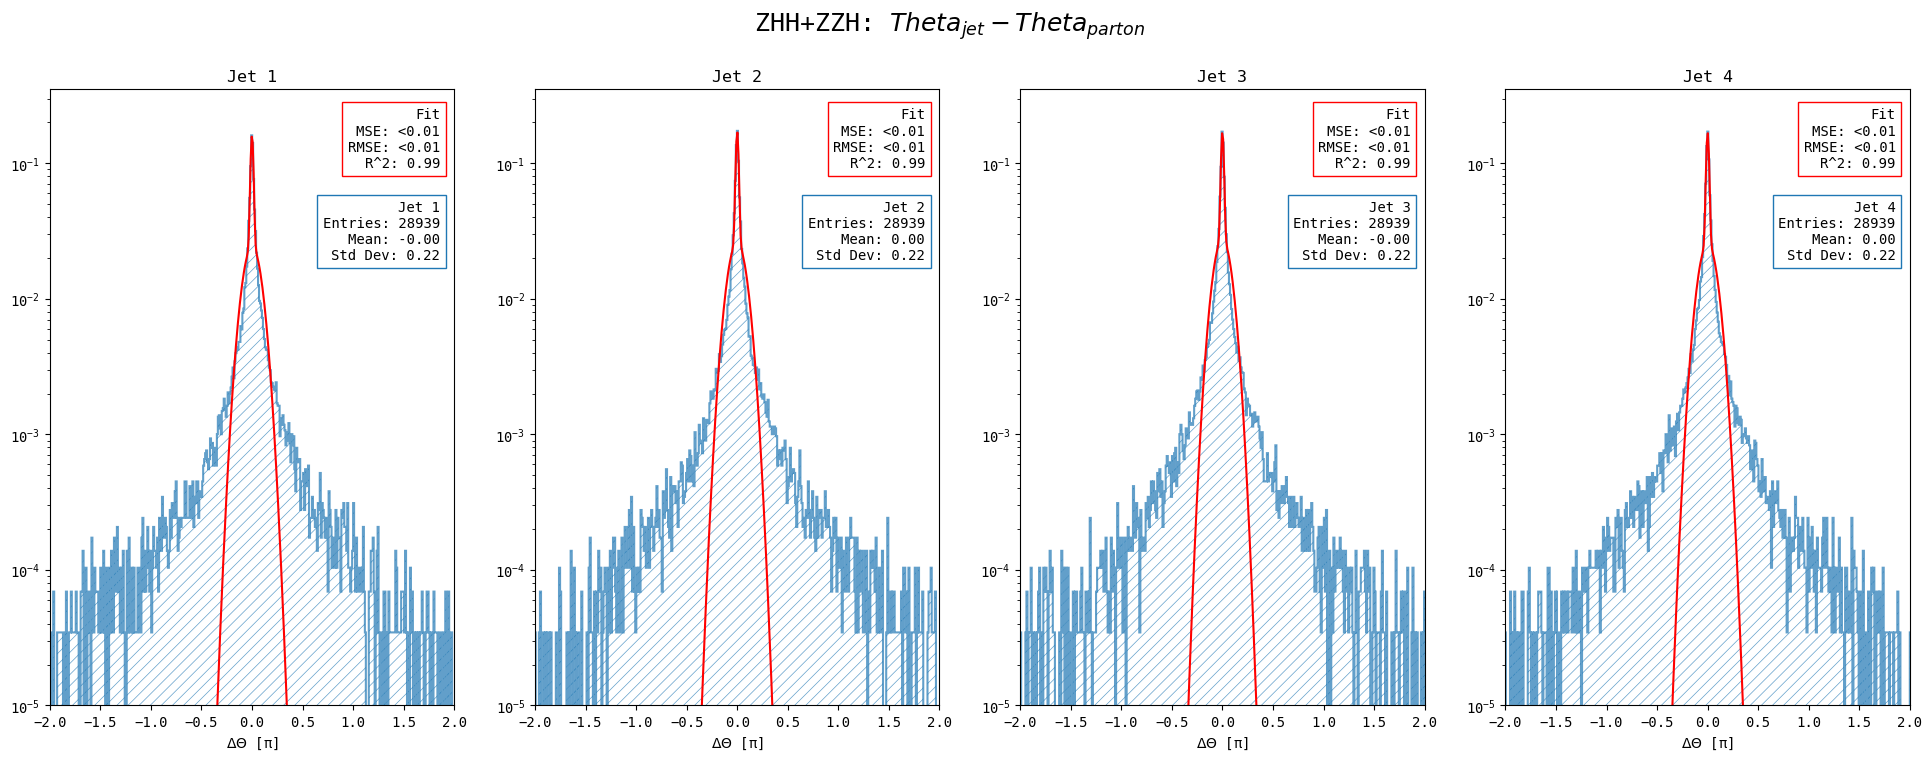

In [81]:
dg = []
fit_init = []
for i in range(4):
    dg.append((df[i][0]["jet"], df[i][0]["parton"]))
    fit_init.append([0, 0.1, 0.08, 0, 0.8])

plot_transfer(dg, "ZHH+ZZH", fit="dbgauss_old", quantity="Theta", xlabel=r"$\Delta\Theta$ [π]", xlim=(-2,2), binrange=(-2,2), ylim=(0.00001,0.35), fit_skip=False, n_bins=512, fit_init=fit_init, yscale="log")

[-6.74030393e-05  1.92978094e-02]
[-6.16726155e-05  1.97475703e-02]
[4.01348158e-05 1.97618786e-02]
[1.71875712e-05 1.97237870e-02]


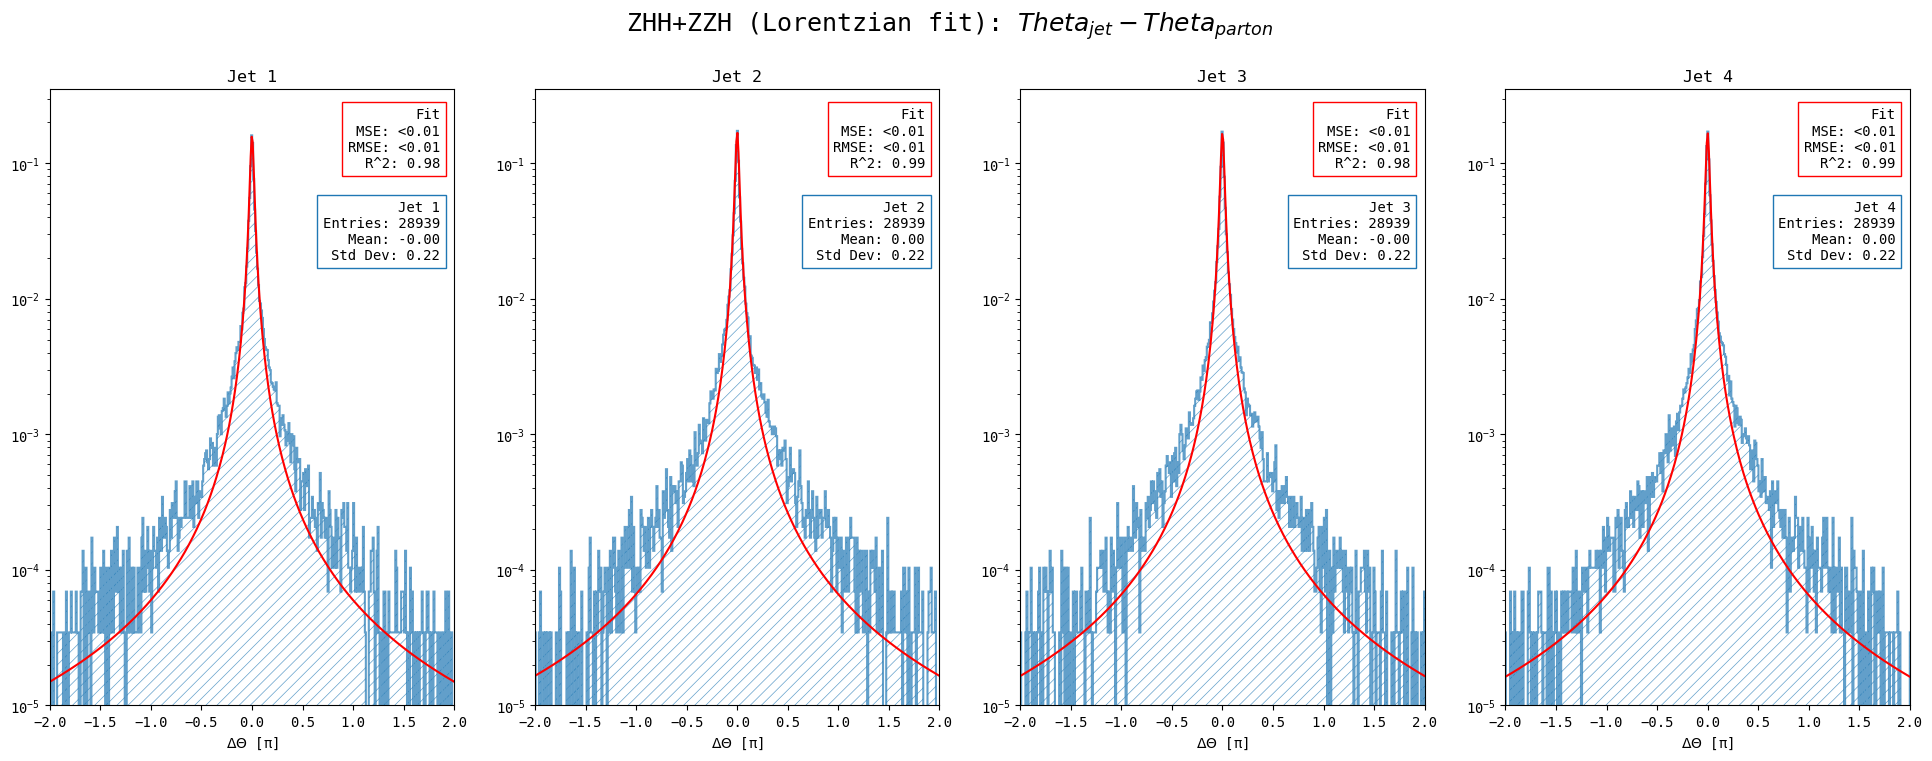

In [8]:
dg = []
for i in range(4):
    dg.append((df[i][0]["jet"], df[i][0]["parton"]))

plot_transfer(dg, "ZHH+ZZH (Lorentzian fit)", fit="lorentz", quantity="Theta", xlabel=r"$\Delta\Theta$ [π]", xlim=(-2,2), ylim=(0.00001,0.35), n_bins=512, yscale="log")

[7.25520248e-05 1.41488055e-02]
[-1.21860464e-05  1.43008677e-02]
[-0.00020607  0.01421485]
[0.0001609  0.01452313]


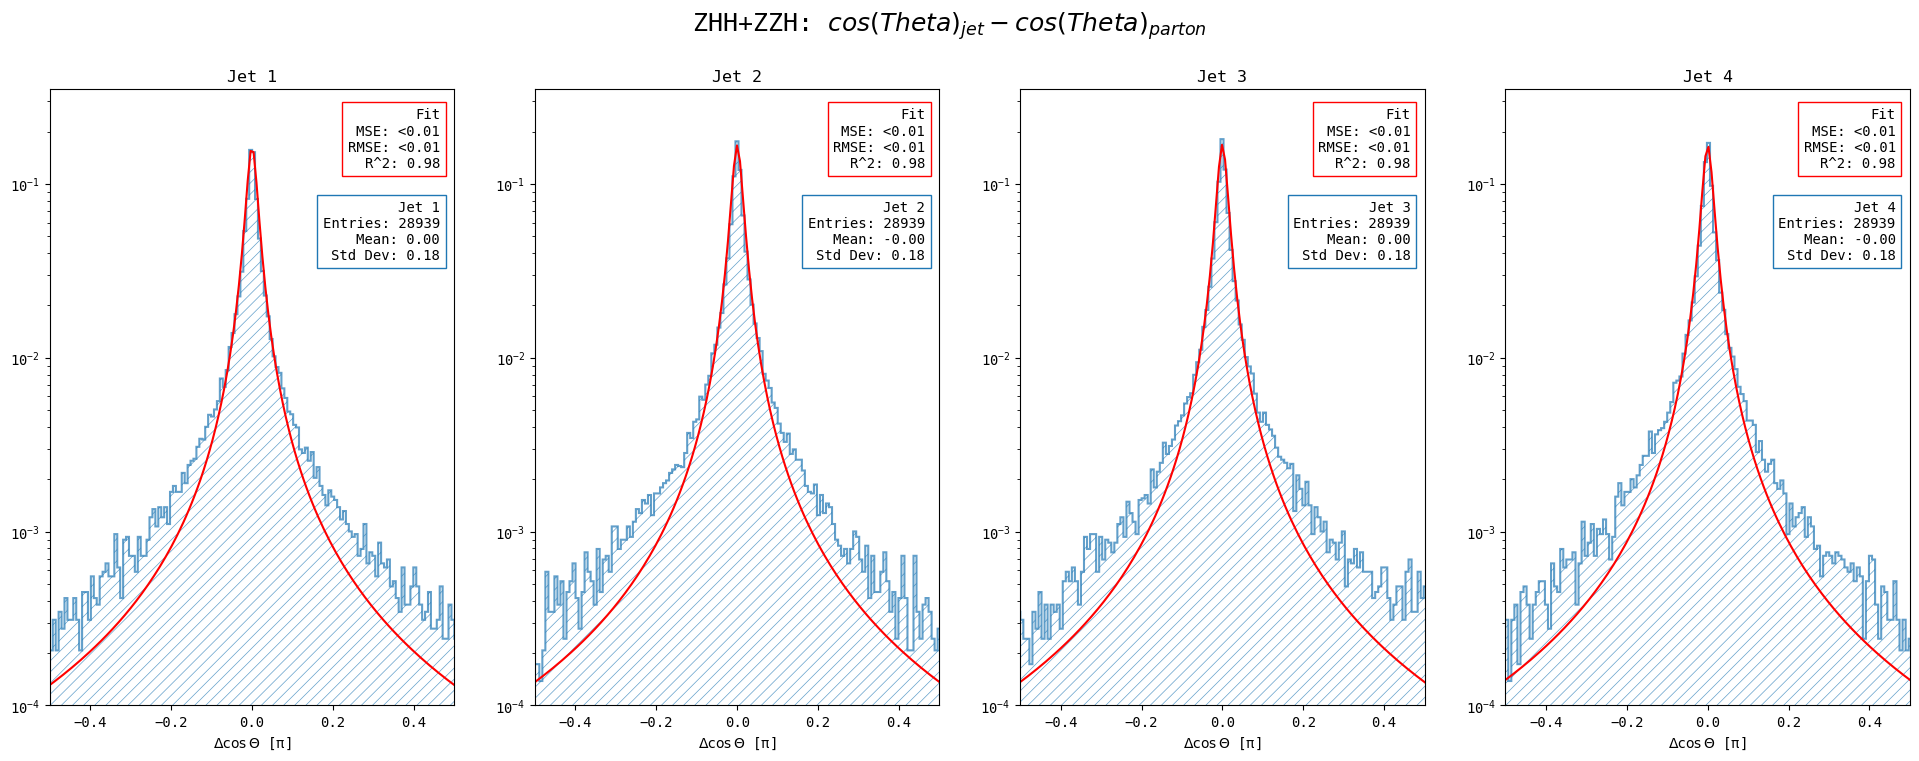

In [84]:
dg = []
for i in range(4):
    dg.append((np.cos(df[i][0]["jet"]), np.cos(df[i][0]["parton"])))

plot_transfer(dg, "ZHH+ZZH", fit="lorentz", quantity="cos(Theta)", xlabel=r"$\Delta\cos{\Theta}$ [π]", xlim=(-0.5,0.5), ylim=(0.0001,0.35), n_bins=512, yscale="log")

Phi

[0.00062912 0.02822982]
[0.00059001 0.02783513]
[-2.34602440e-06  2.82045433e-02]
[-0.00043269  0.02854085]


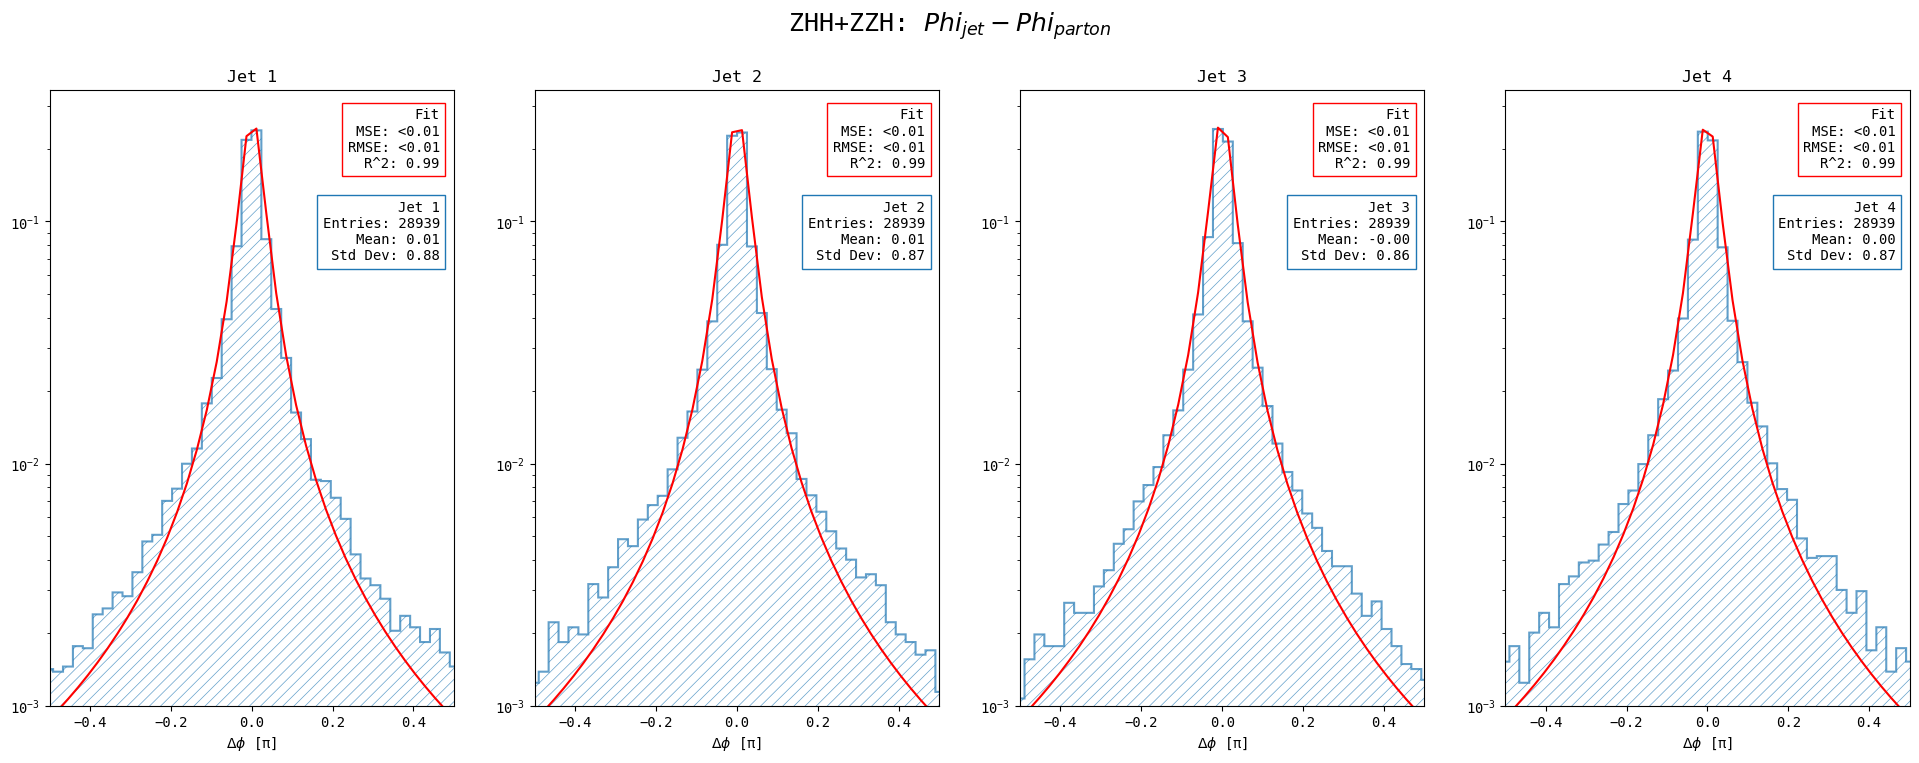

In [81]:
dg = []
for i in range(4):
    dg.append((df[i][1]["jet"], df[i][1]["parton"]))

plot_transfer(dg, "ZHH+ZZH", fit="lorentz", quantity="Phi", xlabel=r"$\Delta\phi$ [π]", xlim=(-0.5,0.5), ylim=(0.001,0.35), n_bins=512, yscale="log")

[0.00078317 0.02199607]
[0.00059999 0.02076936]
[0.00016838 0.0201623 ]
[-0.00045808  0.02265684]


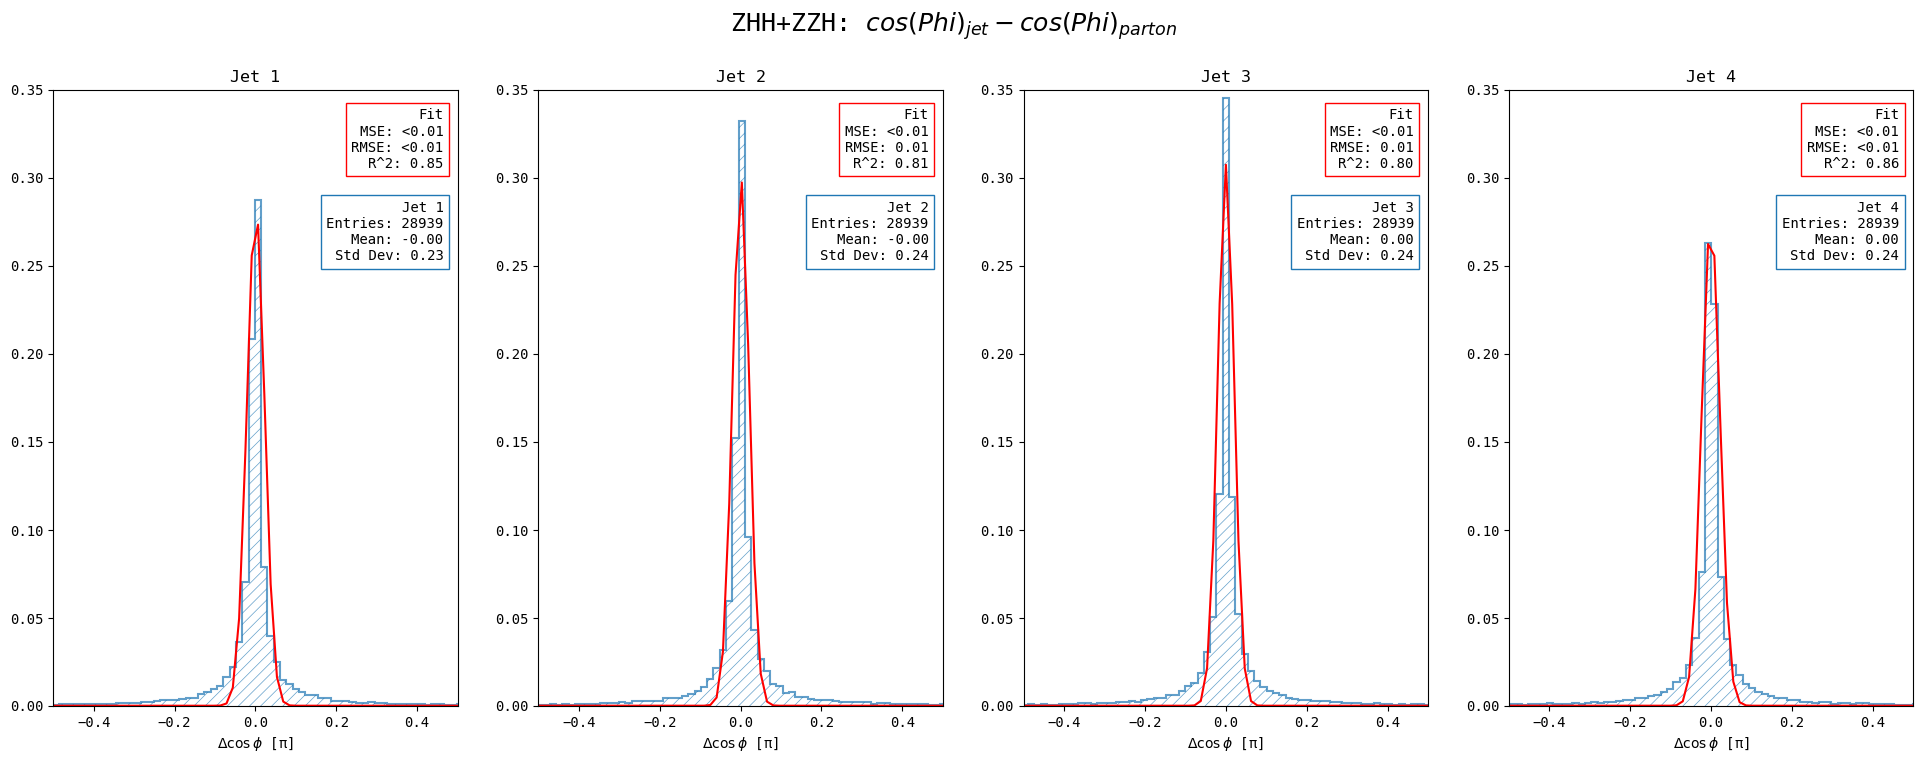

In [165]:
dg = []
for i in range(4):
    dg.append((np.cos(df[i][1]["jet"]), np.cos(df[i][1]["parton"])))

plot_transfer(dg, "ZHH+ZZH", fit="gauss", quantity="cos(Phi)", xlabel=r"$\Delta\cos{\phi}$ [π]", xlim=(-0.5,0.5), ylim=(0,0.35), n_bins=256)

Check masses

Muon

In [12]:
m_mu1 = []
m_mu2 = []
for event_idx in range(10000):
    m_mu1.append(
        sqrt(reco["true_lep1_e"][event_idx]**2 - (
            reco["true_lep1_px"][event_idx]**2 +
            reco["true_lep1_py"][event_idx]**2 +
            reco["true_lep1_pz"][event_idx]**2
        ))
    )
    
    m_mu2.append(
        sqrt(reco["true_lep2_e"][event_idx]**2 - (
            reco["true_lep2_px"][event_idx]**2 +
            reco["true_lep2_py"][event_idx]**2 +
            reco["true_lep2_pz"][event_idx]**2
        ))
    )
m_mu1 = np.array(m_mu1)
m_mu2 = np.array(m_mu2)

In [13]:
(np.average(m_mu1) + np.average(m_mu2))/2

0.1056357046473643

B-Quark

In [117]:
b1_m = []
b2_m = []
b3_m = []
b4_m = []

for i in range(10000):
    b1_mass = sqrt(reco["parton1_e"][event_idx]**2 - (
        reco["parton1_px"][event_idx]**2 +
        reco["parton1_py"][event_idx]**2 +
        reco["parton1_pz"][event_idx]**2
    ))
    
    b2_mass = sqrt(reco["parton2_e"][event_idx]**2 - (
        reco["parton2_px"][event_idx]**2 +
        reco["parton2_py"][event_idx]**2 +
        reco["parton2_pz"][event_idx]**2
    ))
    
    b3_mass = sqrt(reco["parton3_e"][event_idx]**2 - (
        reco["parton3_px"][event_idx]**2 +
        reco["parton3_py"][event_idx]**2 +
        reco["parton3_pz"][event_idx]**2
    ))
    
    b4_mass = sqrt(reco["parton4_e"][event_idx]**2 - (
        reco["parton4_px"][event_idx]**2 +
        reco["parton4_py"][event_idx]**2 +
        reco["parton4_pz"][event_idx]**2
    ))
    
    b1_m.append(b1_mass)
    b2_m.append(b2_mass)
    b3_m.append(b3_mass)
    b4_m.append(b4_mass)
    
    #if not b1_mass == b2_mass:
    #    print((b1_mass, b2_mass))
    
b1_m = np.array(b1_m)
b2_m = np.array(b2_m)
b3_m = np.array(b3_m)
b4_m = np.array(b4_m)

In [118]:
(np.average(b1_m), np.average(b2_m), np.average(b3_m), np.average(b4_m))

(4.799996415562561, 4.800106704821404, 4.8000320760331565, 4.8000530509804245)

In [16]:
(np.average(b1_m) + np.average(b2_m) + np.average(b3_m) + np.average(b4_m))/4

4.799957253499145

H- and Z-Boson

In [66]:
from math import sqrt

Zm = []
Hm = []

for event_idx in np.where(reco["is_zzh"] == True)[0]:
    H_mass = sqrt(
        (reco["parton3_e"][event_idx]+reco["parton4_e"][event_idx])**2 -
        ((reco["parton3_px"][event_idx]+reco["parton4_px"][event_idx])**2 +
        (reco["parton3_py"][event_idx]+reco["parton4_py"][event_idx])**2 +
        (reco["parton3_pz"][event_idx]+reco["parton4_pz"][event_idx])**2)
    )
    
    Z_mass = sqrt(
        (reco["parton1_e"][event_idx]+reco["parton2_e"][event_idx])**2 -
        ((reco["parton1_px"][event_idx]+reco["parton2_px"][event_idx])**2 +
        (reco["parton1_py"][event_idx]+reco["parton2_py"][event_idx])**2 +
        (reco["parton1_pz"][event_idx]+reco["parton2_pz"][event_idx])**2)
    )
    
    Zm.append(Z_mass)
    Hm.append(H_mass)

Zm = np.array(Zm)
Hm = np.array(Hm)

Z-mass: 91.67587744212345  H-mass: 125.00000005284181


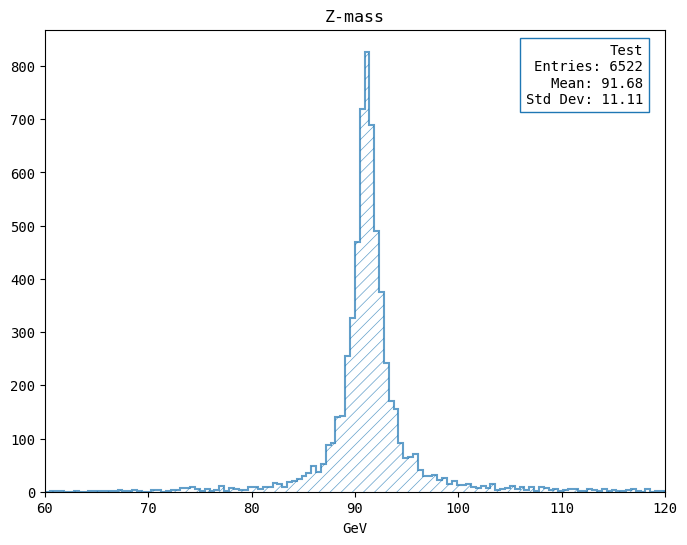

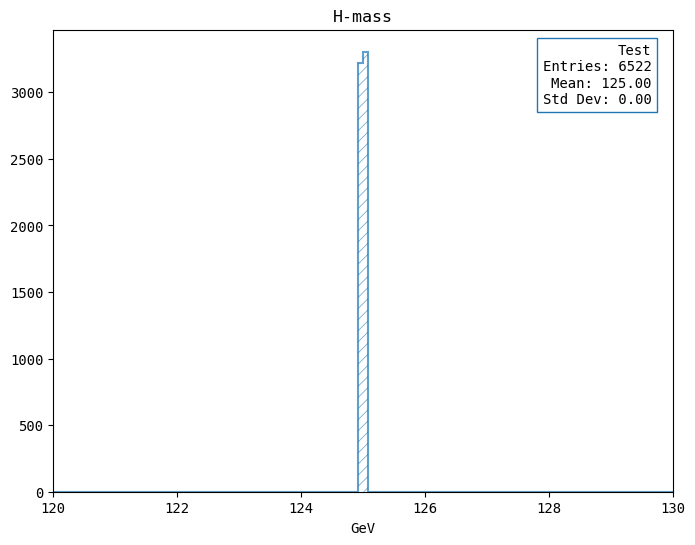

In [70]:
print("Z-mass:", Zm.mean(), " H-mass:", Hm.mean())
plot_hist(Zm, x="Test", xlim=(60, 120), xlim_binning=True, title="Z-mass", xlabel="GeV")
plot_hist(Hm, x="Test", xlim=(120, 130), xlim_binning=True, title="H-mass", xlabel="GeV")

# ISR(+other effects? valid conservation of four momentum in MC sample?) introduces non-zero pT and longitudinal momentum!

Plots for system px,py,pz momenta

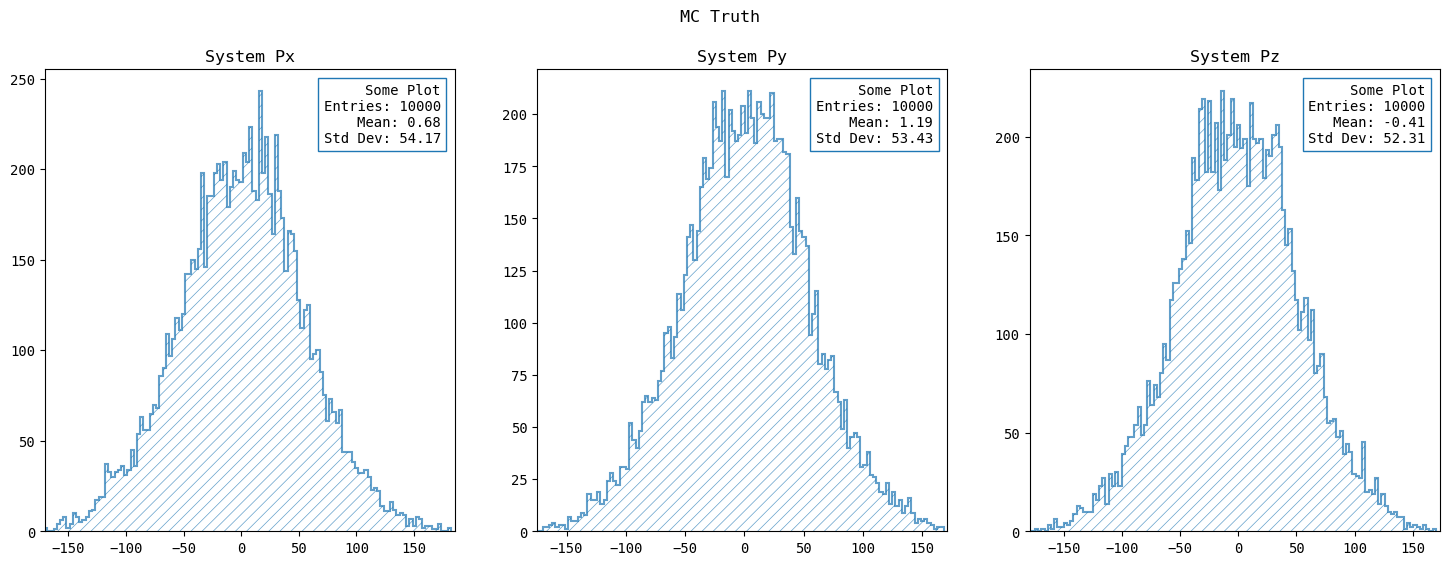

In [6]:
length = 10000
pTruth = (
    np.zeros(length),
    np.zeros(length),
    np.zeros(length)
)

for j in range(length):
    for i, qty in enumerate(["px", "py", "pz"]):
        for part in ["true_lep1", "true_lep2", "parton1", "parton2", "parton3", "parton4"]:
            pTruth[i][j] = reco[f"{part}_{qty}"][j]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("MC Truth")

plot_hist(pTruth[0], x=None, title="System Px", ax=axes[0])
plot_hist(pTruth[1], x=None, title="System Py", ax=axes[1])
plot_hist(pTruth[2], x=None, title="System Pz", ax=axes[2])

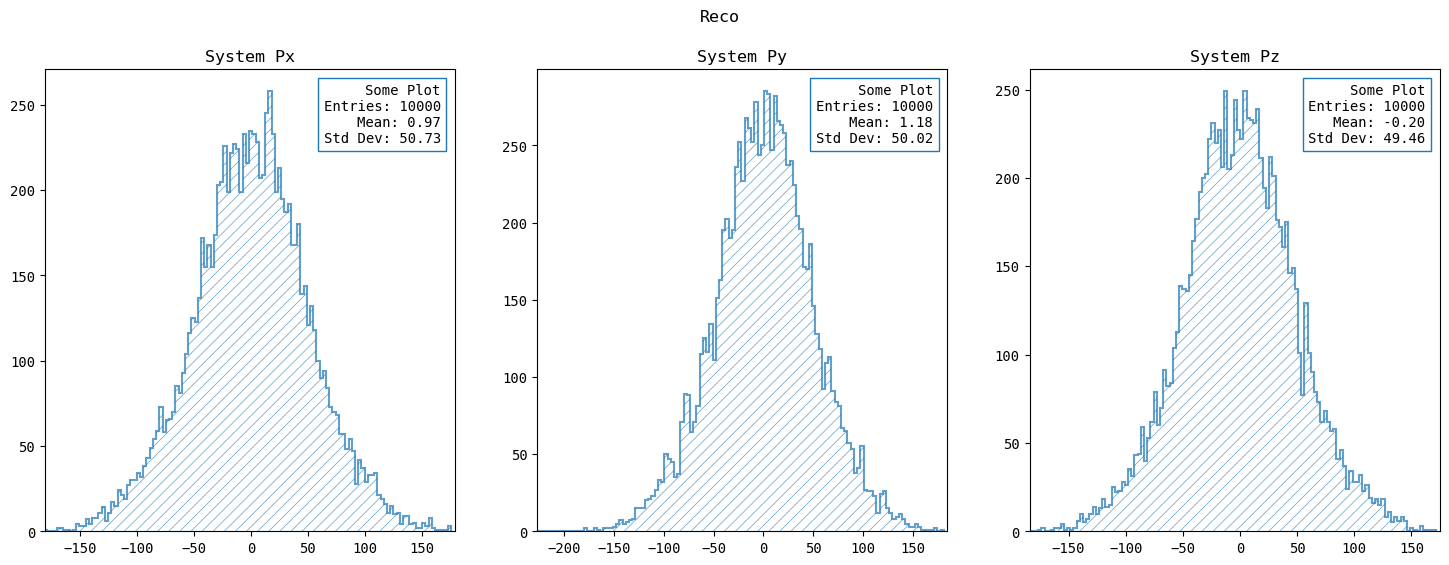

In [140]:
length = 10000
pReco = (
    np.zeros(length),
    np.zeros(length),
    np.zeros(length)
)

for j in range(length):
    for i, qty in enumerate(["px", "py", "pz"]):
        for part in ["lep1", "lep2", "jet1", "jet2", "jet3", "jet4"]:
            pReco[i][j] = reco[f"{part}_{qty}"][j]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Reco")

plot_hist(pReco[0], x=None, title="System Px", ax=axes[0])
plot_hist(pReco[1], x=None, title="System Py", ax=axes[1])
plot_hist(pReco[2], x=None, title="System Pz", ax=axes[2])

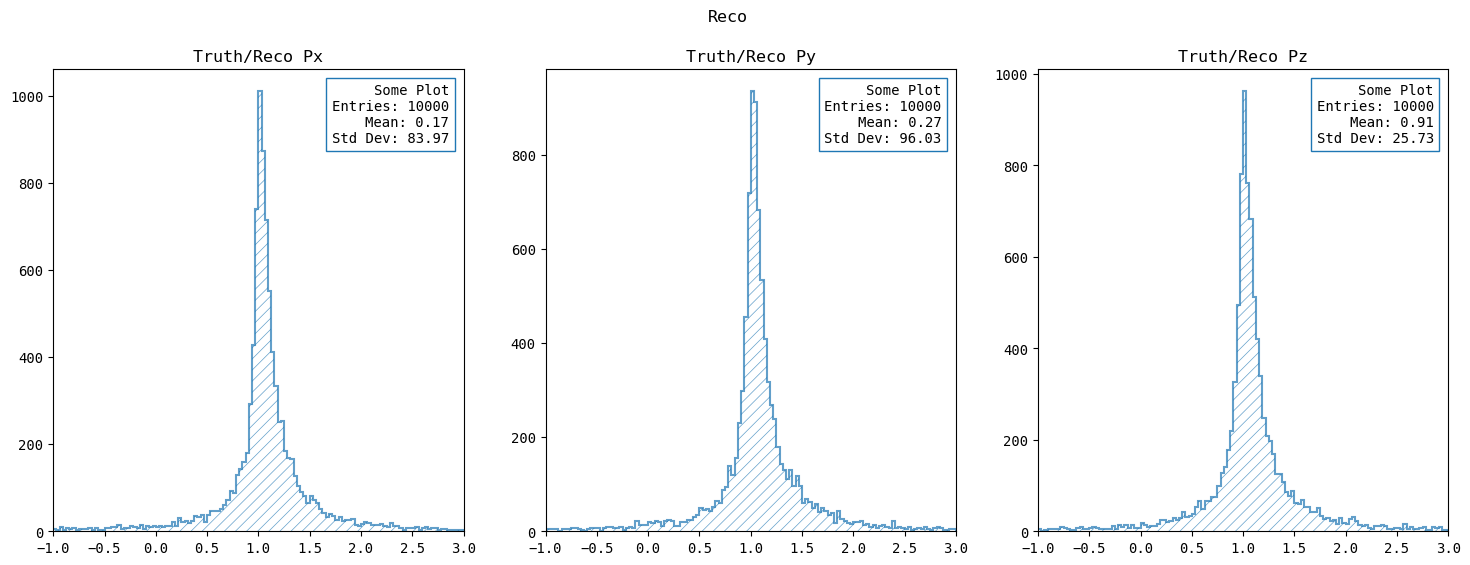

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Reco")

xlim = xlim_binning = (-1,3)
plot_hist(pTruth[0]/pReco[0], x=None, title="Truth/Reco Px", ax=axes[0], xlim_binning=xlim_binning, xlim=xlim)
plot_hist(pTruth[1]/pReco[1], x=None, title="Truth/Reco Py", ax=axes[1], xlim_binning=xlim_binning, xlim=xlim)
plot_hist(pTruth[2]/pReco[2], x=None, title="Truth/Reco Pz", ax=axes[2], xlim_binning=xlim_binning, xlim=xlim)

Rho Jets

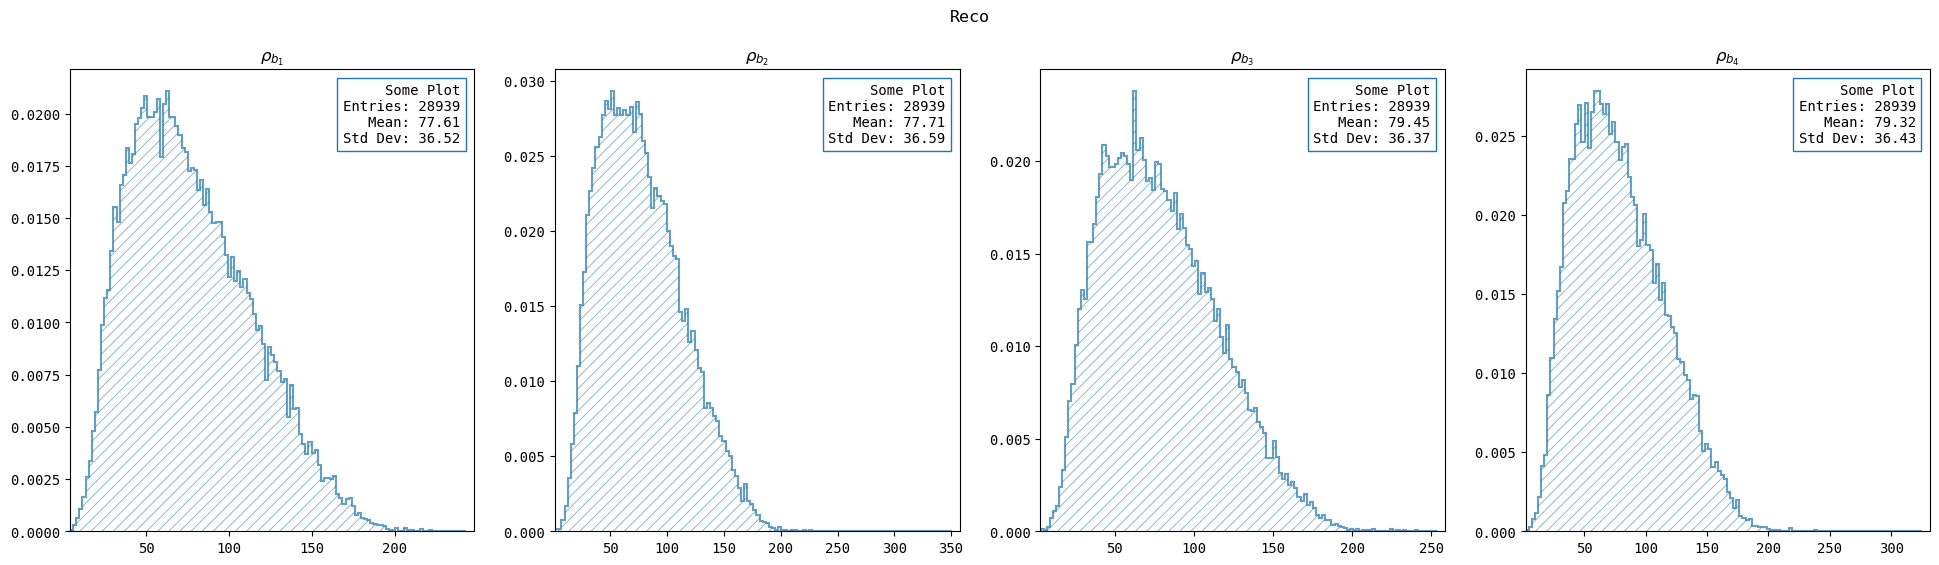

In [3]:
length = 10000
rhoReco = []

for part in ["jet1", "jet2", "jet3", "jet4"]:
    rhoReco.append(np.sqrt(reco[f"{part}_px"]**2 + reco[f"{part}_py"]**2 + reco[f"{part}_pz"]**2))

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle("Reco")

plot_hist(rhoReco[0], x=None, title=r"$\rho_{b_1}$", ax=axes[0], normalize=True)
plot_hist(rhoReco[1], x=None, title=r"$\rho_{b_2}$", ax=axes[1], normalize=True)
plot_hist(rhoReco[2], x=None, title=r"$\rho_{b_3}$", ax=axes[2], normalize=True)
plot_hist(rhoReco[3], x=None, title=r"$\rho_{b_4}$", ax=axes[3], normalize=True)

## Priors / Preconditioning

[77.17406236 38.99397172]


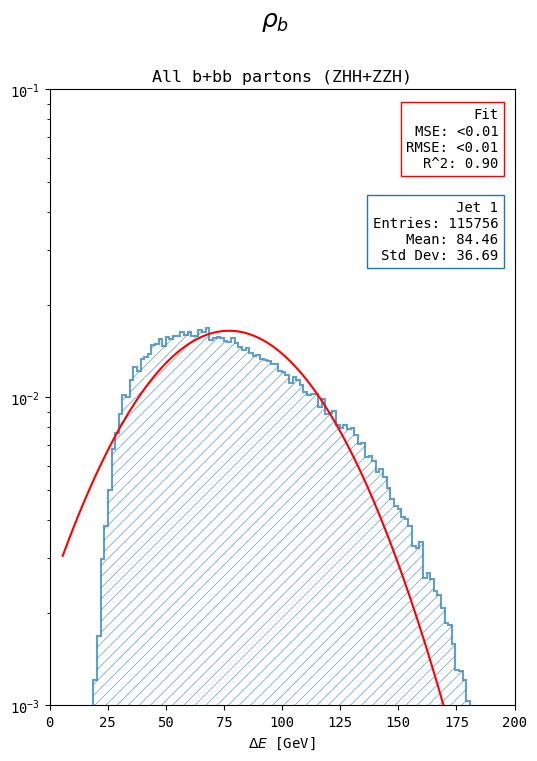

In [236]:
df = np.array([])

for part in ["parton1", "parton2", "parton3", "parton4"]:
    df = np.append(df, (np.sqrt(reco[f"{part}_px"]**2 + reco[f"{part}_py"]**2 + reco[f"{part}_pz"]**2)))
    
df = [(df, np.zeros(len(df)))]

plot_transfer(df, "", suptitle=r"$\rho_b$", single_title="All b+bb partons (ZHH+ZZH)", n_bins=128, xlim=(0, 200), ylim=(0.001, 0.1), yscale="log")

[1.57131127 0.78054955]


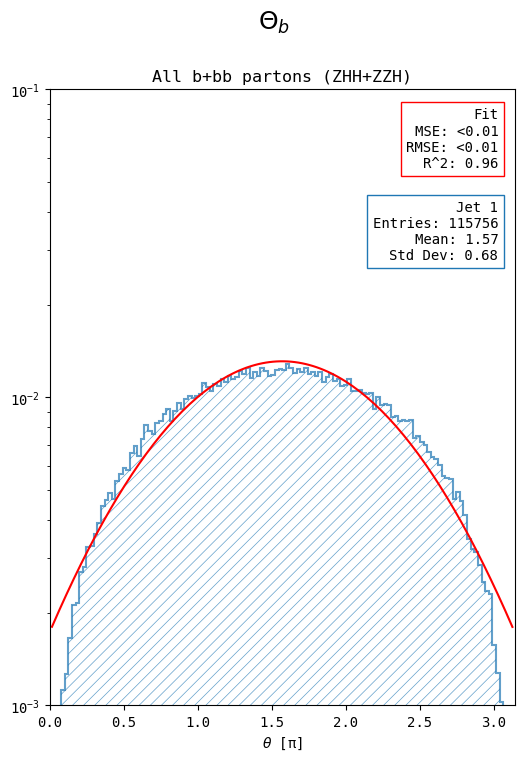

In [268]:
# Theta
df = np.array([])

for part in ["parton1", "parton2", "parton3", "parton4"]:
    x = reco[f"{part}_px"]
    y = reco[f"{part}_py"]
    z = reco[f"{part}_pz"]
    df = np.append(df, (np.arccos(z/np.sqrt(x**2 + y**2 + z**2))))
    
df = [(df, np.zeros(len(df)))]

plot_transfer(df, "", suptitle=r"$\Theta_b$", xlabel=r"$\theta$ [π]", single_title="All b+bb partons (ZHH+ZZH)", n_bins=128, xlim=(0, pi), ylim=(0.001, 0.1), yscale="log")

[0.15916048]


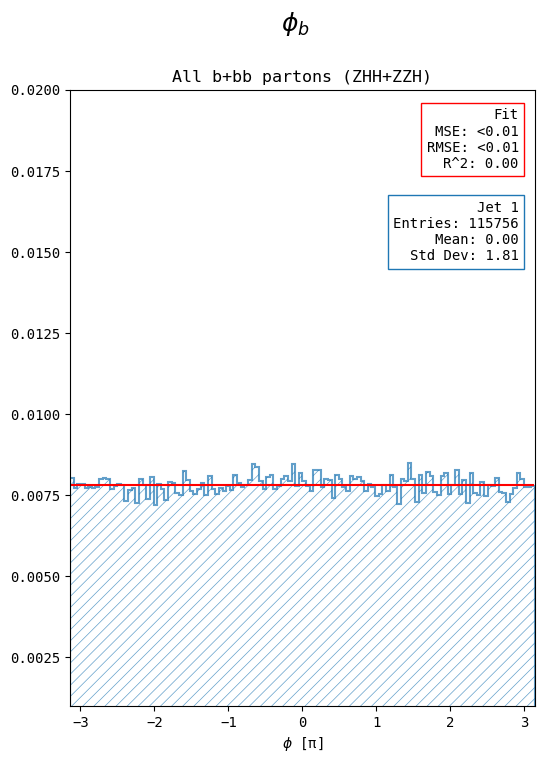

In [266]:
# Phi
df = np.array([])

for part in ["parton1", "parton2", "parton3", "parton4"]:
    x = reco[f"{part}_px"]
    y = reco[f"{part}_py"]
    z = reco[f"{part}_pz"]
    df = np.append(df, (np.arctan2(y, x)))
    
df = [(df, np.zeros(len(df)))]

plot_transfer(df, "", suptitle=r"$\phi_b$", fit="uniform", xlabel=r"$\phi$ [π]", single_title="All b+bb partons (ZHH+ZZH)", n_bins=128, xlim=(-pi, pi), ylim=(0.001, 0.02))

Calculation v2

In [3]:
from analysis.mem_python import get_kinematics_from_int
from analysis.mem import get_evt_constants, int_bf_v2, get_kinematics_tf
from analysis.cffi.mg5.lib import calc_kinematics_from_int,lib_options

def get_true_int_args(data, event_idx:int, constants:dict, nwa=lib_options["NWA"]):
    energies, momenta, angles = get_kinematics_tf(data, event_idx, 0)
    
    Thb1,Phb1 = angles[2]
    Rhb1 = momenta[2]
    
    Thb1b, Phb1b = angles[3]
    
    Rhb2 = momenta[4]
    Thb2 = angles[4][0]
    
    int_variables = Thb1, Phb1, Rhb1, Thb1b, Phb1b, Rhb2, Thb2
    evt_constants = get_evt_constants(data, event_idx, constants, False)
    
    kin = get_kinematics(data, True, event_idx)
    
    return int_variables, evt_constants, kin

Example

In [5]:
int_variables = [ 0.00000000e+00, -3.14159265e+00,  6.66666667e+01,
        2.09439510e+00, -3.14159265e+00,  6.66666667e+01,  2.09439510e+00]

evt_constants = [
        4.8,
        1e-3,
        1.0,
        1.0,
        500.,
        *[get_evt_constants(reco, 0)[i] for i in ["system_E", "system_px", "system_py", "system_pz"]]
]

calc_kinematics_from_int(int_variables, evt_constants)

dE:5.68434e-14
dp:4.08562e-14
----------------------------------------------------
Spherical coordinates:
Particle 1: 66.6667 0 -3.14159 
Particle 2: 77.6615 2.0944 -3.14159 
Particle 3: 66.6667 2.0944 -1.25717 
Particle 4: 133.143 2.25504 -0.114827 

Four-vectors:
Particle 1: 66.8392 -0 -0 66.6667 
Particle 2: 77.8097 -67.2569 -2.41438e-07 -38.8308 
Particle 3: 66.8392 17.812 -54.9187 -33.3333 
Particle 4: 133.229 102.493 -11.8209 -84.1576 
----------------------------------------------------


1

In [35]:
from analysis.mem_python import err_map
from analysis.mem import unit_vec
from math import acos,asin,copysign,atan2,atan,pi,sqrt,cos,sin

def get_kinematics_from_int(int_variables, constants:dict, return_p_in=False, return_spherical=False, epsilon:float=1e-3, err_map=err_map, do_check=True, dEmax:float=1., dpmax:float=1., nwa=True):
    """_summary_

    Args:
        int_variables (_type_): _description_
        constants (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    mH2 = Thb1 = Phb1 = Rhb1 = Thb1b = Phb1b = Rhb2 = Thb2 = 0
    if nwa:
        mH2 = 125.**2
        Thb1, Phb1, Rhb1, Thb1b, Phb1b, Rhb2, Thb2 = int_variables
    else:
        mH2, Thb1, Phb1, Rhb1, Thb1b, Phb1b, Rhb2, Thb2 = int_variables
    
    print("Thb2:", Thb2)
    print("Rhb2:", Rhb2)
    
    b1E = sqrt(constants["m_b"]**2 + Rhb1**2)
    
    b1e = unit_vec(Thb1, Phb1)
    b1p = Rhb1*b1e
    
    # Calculate Rhb1b from mH2, Rhb1 and angles
    b1be = unit_vec(Thb1b, Phb1b)
    dot = np.dot(b1e, b1be)
    
    dmH2 = (mH2-2*constants["m_b"]**2)/2
    d = (dmH2*Rhb1*dot)/(Rhb1**2*dot**2 - b1E**2)
    
    arg_Rhb1b_sqrt = ((b1E**2)*(constants["m_b"]**2) - dmH2**2)/((Rhb1**2)*(dot**2) - b1E**2) + d**2
    if arg_Rhb1b_sqrt < 0:
        return err_map[1]
    
    #Rhb1b2 = -d -sqrt(arg_Rhb1b_sqrt) # negative solution
    Rhb1b = -d +sqrt(arg_Rhb1b_sqrt)
    if Rhb1b < 0:
        return err_map[2]
    
    b1bp1 = Rhb1b*b1be
    #b1bp2 = Rhb1b2*b1be
    
    b1bE1 = sqrt(constants["m_b"]**2 + Rhb1b**2)
    
    # Calculate pH and from that pB2
    pB2 = np.array([
        constants["system_E"] -(b1E+b1bE1),
        constants["system_px"] -b1p[0] -b1bp1[0],
        constants["system_py"] -b1p[1] -b1bp1[1],
        constants["system_pz"] -b1p[2] -b1bp1[2],
    ])
    print("pB2", pB2)
    
    # Calculate Rhb2b
    b2E = sqrt(constants["m_b"]**2 + Rhb2**2)
    print("b2E", b2E)
    
    print("b2bE: pB2[0]-b2E", pB2[0], "-", b2E, "=", pB2[0]-b2E)
    
    b2bE = pB2[0] - b2E
    if b2bE < 0:
        return err_map[5]
    print("b2bE", b2bE)
    
    arg_Rhb2b_sqrt = b2bE**2 - constants["m_b"]**2
    if arg_Rhb2b_sqrt < 0:
        return err_map[6]
    Rhb2b = sqrt(arg_Rhb2b_sqrt)
    print("Rhb2b", Rhb2b)
    
    # Calculate remaining variables, i.e. Thb2b, Phb2b and Phb2
    arg_Thb2b_acos = 1/Rhb2b*(pB2[3] - Rhb2*cos(Thb2))
    if abs(arg_Thb2b_acos) > 1:
        return err_map[7]
    Thb2b = acos(arg_Thb2b_acos)
    
    a = pB2[1]
    b = pB2[2]
    c = (-(Rhb2*sin(Thb2))**2 + (Rhb2b*sin(Thb2b))**2 + a**2 + b**2)/(2*Rhb2b*sin(Thb2b))
    
    arg_Phb2b_atan_sqrt = a**2 + b**2 - c**2
    if arg_Phb2b_atan_sqrt < 0:
        if -arg_Phb2b_atan_sqrt < epsilon:
            arg_Phb2b_atan_sqrt = 0
        else:
            return err_map[8]
    
    # Two solutions to calculate Phb2b with atan; try out both, use the one that is closest to target   
    Phb2b_1 = 2*atan((b+ sqrt(arg_Phb2b_atan_sqrt))/(a+c))
    Phb2b_2 = 2*atan((b- sqrt(arg_Phb2b_atan_sqrt))/(a+c))
    
    arg_Phb2_1_acos = (a - Rhb2b*sin(Thb2b)*cos(Phb2b_1))/(Rhb2*sin(Thb2))
    arg_Phb2_2_acos = (a - Rhb2b*sin(Thb2b)*cos(Phb2b_2))/(Rhb2*sin(Thb2))
    
    if abs(arg_Phb2_1_acos) and abs(arg_Phb2_2_acos) > 1:
        return err_map[9]
    
    # Check which solution is better    
    Phb2 = 0
    Phb2b = 0
    if abs(arg_Phb2_1_acos) > 1:
        Phb2b = Phb2b_2
        Phb2 = acos(arg_Phb2_2_acos)
        
        if (pB2[2] - Rhb2b*sin(Thb2b)*sin(Phb2b))/(sin(Thb2)) < 0:
            Phb2 = -Phb2
    elif abs(arg_Phb2_2_acos) > 1:
        Phb2b = Phb2b_1
        Phb2 = acos(arg_Phb2_1_acos)
        
        if (pB2[2] - Rhb2b*sin(Thb2b)*sin(Phb2b))/(sin(Thb2)) < 0:
            Phb2 = -Phb2
    else:
        Phb2_1 = acos(arg_Phb2_1_acos)
        Phb2_2 = acos(arg_Phb2_2_acos)
        
        #print("Sign Hint")
        #print((pB2[1] - Rhb2b*sin(Thb2b)*cos(Phb2b_1))/(sin(Thb2)))
        #print((pB2[1] - Rhb2b*sin(Thb2b)*cos(Phb2b_2))/(sin(Thb2)))
        
        if (pB2[2] - Rhb2b*sin(Thb2b)*sin(Phb2b_1))/(sin(Thb2)) < 0:
            Phb2_1 = -Phb2_1
            
        if (pB2[2] - Rhb2b*sin(Thb2b)*sin(Phb2b_2))/(sin(Thb2)) < 0:
            Phb2_2 = -Phb2_2
        
        b2_1p = Rhb2*unit_vec(Thb2, Phb2_1)
        b2_2p = Rhb2*unit_vec(Thb2, Phb2_2)
        
        b2b_1p = Rhb2b*unit_vec(Thb2b, Phb2b_1)
        b2b_2p = Rhb2b*unit_vec(Thb2b, Phb2b_2)
        
        B1comp_1 = b2_1p + b2b_1p
        B1comp_2 = b2_2p + b2b_2p
        
        B1check_1 = pB2[1:4] - B1comp_1
        B1check_2 = pB2[1:4] - B1comp_2
        
        if np.dot(B1check_1, B1check_1) < np.dot(B1check_2, B1check_2):
            Phb2 = Phb2_1
            Phb2b = Phb2b_1
        else:
            Phb2 = Phb2_2
            Phb2b = Phb2b_2

    # Finish
    b2e = unit_vec(Thb2, Phb2)
    b2p = Rhb2*b2e
    
    b2be = unit_vec(Thb2b, Phb2b)
    b2bp = Rhb2b*b2be
    
    result = np.array([
        (b1E, *b1p),
        (b1bE1, *b1bp1),
        (b2E, *b2p),
        (b2bE, *b2bp)
    ])
    
    if do_check:
        check = np.array([
            constants["system_E"] - np.sum(result.T[0]),
            constants["system_px"] - np.sum(result.T[1]),
            constants["system_py"] - np.sum(result.T[2]),
            constants["system_pz"] - np.sum(result.T[3])
        ])
        
        dE = check[0]
        dp = sqrt(check[1]**2 + check[2]**2 + check[3]**2)
        
        if dE > dEmax or dp > dpmax:
            return err_map[10]
    
    if return_spherical:
        return (
            np.array([
                Rhb1, Thb1, Phb1,
                Rhb1b, Thb1b, Phb1b,
                Rhb2, Thb2, Phb2,
                Rhb2b, Thb2b, Phb2b
            ]),
            result
        )
    
    if not return_p_in:
        return result
    else:
        return (
            np.array([
                constants["system_E"],
                constants["system_px"],
                constants["system_py"],
                constants["system_pz"]
            ]),
            result
        )


In [9]:
sqrt(
    (reco["parton3_e"][event_idx]+reco["parton4_e"][event_idx])**2 -
    ((reco["parton3_px"][event_idx]+reco["parton4_px"][event_idx])**2 +
    (reco["parton3_py"][event_idx]+reco["parton4_py"][event_idx])**2 +
    (reco["parton3_pz"][event_idx]+reco["parton4_pz"][event_idx])**2)
)

125.00000359532017

In [10]:
sqrt(
    (reco["parton1_e"][event_idx]+reco["parton2_e"][event_idx])**2 -
    ((reco["parton1_px"][event_idx]+reco["parton2_px"][event_idx])**2 +
    (reco["parton1_py"][event_idx]+reco["parton2_py"][event_idx])**2 +
    (reco["parton1_pz"][event_idx]+reco["parton2_pz"][event_idx])**2)
)

125.00000445710108

# ISR!!!!! difference between True energy and sqrt(s)-mu1E-mu2E !!!

In [48]:
event_idx = 0

energies, momenta, angles = get_kinematics_tf(reco, event_idx, 0)
fm = np.array(get_kinematics(reco, 1, event_idx)).reshape((6,4))
evt_constants = get_evt_constants(reco, event_idx, constants, False)

momenta = momenta[2:6]
angles = angles[2:6]
print(np.array([momenta.T, *angles.T]).T)

pB2 = np.array([
    evt_constants["system_E"] -(fm[2][0] + fm[3][0]),
    evt_constants["system_px"] -fm[2][1] -fm[3][1],
    evt_constants["system_py"] -fm[2][2] -fm[3][2],
    evt_constants["system_pz"] -fm[2][3] -fm[3][3],
])
print("pB2:", pB2)
print("Rhb2", momenta[2])
print("b2E", energies[4])
print("b2E:Pred", sqrt(constants["m_b"]**2 + momenta[2]**2))



print("b2bE", energies[5])
print("b2bE:Pred", sqrt(constants["m_b"]**2 + momenta[3]**2))

print("b2bE:PredpB2", pB2[0] - energies[4])

print("b2E+b2bE", energies[4] + energies[5])

[[ 32.67671167   0.36454211   0.70659516]
 [157.99854316   1.97444387  -1.27383843]
 [ 81.5537031    2.16689201   2.58112485]
 [ 69.52776429   1.71717767   0.42615042]]
pB2: [153.48898888   1.9816452   64.30821307 -58.34164745]
Rhb2 81.55370310004278
b2E 81.69484
b2E:Pred 81.6948350813278
b2bE 69.69326
b2bE:Pred 69.69325359498166
b2bE:PredpB2 71.79414939880371
b2E+b2bE 151.38809


In [42]:
int_variables, evt_constants, kin = get_true_int_args(reco, event_idx, constants)

sph, kin = get_kinematics_from_int(int_variables, evt_constants, return_spherical=True)
print(sph.reshape((4,3)))
print(kin.reshape((4,4)))

Thb2: 2.16689200614355
Rhb2: 81.55370310004278
pB2 [153.48897329   1.98163825  64.30823578 -58.3416373 ]
b2E 81.6948350813278
b2bE: pB2[0]-b2E 153.48897329163495 - 81.6948350813278 = 71.79413821030715
b2bE 71.79413821030715
Rhb2b 71.63350257892787
[[ 32.67671167   0.36454211   0.70659516]
 [157.99856899   1.97444387  -1.27383843]
 [ 81.5537031    2.16689201   0.4119333 ]
 [ 71.63350258   1.74698903   2.58451097]]
[[  33.02736858    8.86068344    7.5637064    30.52943039]
 [ 158.07146293   42.51688317 -138.94126111  -62.05794395]
 [  81.69483508   61.84293934   27.02113764  -45.78553772]
 [  71.79413821  -59.86130108   37.28709814  -12.55609958]]


In [31]:
mc_batch(get_kinematics(reco, False, 0), int_variables, mode=1)

dE:2.84217e-14
dp:3.55271e-14
----------------------------------------------------
Spherical coordinates:
Particle 1: 32.6767 0.364542 0.706595 
Particle 2: 157.999 1.97444 -1.27384 
Particle 3: 81.5537 2.16689 0.416751 
Particle 4: 71.7635 1.74362 2.58548 

Four-vectors:
Particle 1: 33.0274 8.86068 7.56371 30.5294 
Particle 2: 158.071 42.5169 -138.941 -62.0579 
Particle 3: 81.6948 61.712 27.3188 -45.7855 
Particle 4: 71.9238 -60.0416 37.3191 -12.3407 
----------------------------------------------------
Found PS-point at [0]
----------------------------------------------------
mc_batch full_kin [
Particle 1: 250 0 0 250 
Particle 2: 250 0 0 -250 
Particle 3: 18.6301 13.8834 -12.407 0.605598 
Particle 4: 136.652 -66.9314 79.1467 89.0491 
Particle 5: 33.0274 8.86068 7.56371 30.5294 
Particle 6: 158.071 42.5169 -138.941 -62.0579 
Particle 7: 81.6948 61.712 27.3188 -45.7855 
Particle 8: 71.9238 -60.0416 37.3191 -12.3407 
]

----------------------------------------------------
------------

[9.514801141726182e-28]

In [32]:
int_variables, evt_constants, kin = get_true_int_args(reco, event_idx, constants)
mc_batch(kin, int_variables, mode=1)

dE:2.84217e-14
dp:2.24693e-14
----------------------------------------------------
Spherical coordinates:
Particle 1: 32.6767 0.364542 0.706595 
Particle 2: 157.999 1.97444 -1.27384 
Particle 3: 81.5537 2.16689 0.411933 
Particle 4: 71.6335 1.74699 2.58451 

Four-vectors:
Particle 1: 33.0274 8.86068 7.56371 30.5294 
Particle 2: 158.071 42.5169 -138.941 -62.0579 
Particle 3: 81.6948 61.843 27.0211 -45.7855 
Particle 4: 71.7942 -59.8613 37.2871 -12.5561 
----------------------------------------------------
Found PS-point at [0]
----------------------------------------------------
mc_batch full_kin [
Particle 1: 250 0 0 250 
Particle 2: 250 0 0 -250 
Particle 3: 136.987 -67.0913 79.3393 89.2716 
Particle 4: 18.4253 13.7321 -12.27 0.598593 
Particle 5: 33.0274 8.86068 7.56371 30.5294 
Particle 6: 158.071 42.5169 -138.941 -62.0579 
Particle 7: 81.6948 61.843 27.0211 -45.7855 
Particle 8: 71.7942 -59.8613 37.2871 -12.5561 
]

----------------------------------------------------
-------------

[2.1097942376550256e-26]

In [4]:
def lorentzBoost(v4:np.ndarray, boost:np.ndarray):
    b2 = np.dot(boost, boost)
    gamma = 1. / sqrt(1. - b2)
    bp = np.dot(v4[1:4], boost)
    gamma2 = (gamma - 1.)/b2 if b2 > 0 else 0.
    
    return np.array([
      gamma*(v4[0] + bp),
      v4[1] + boost[0]*(gamma2*bp* + gamma*v4[0]),
      v4[2] + boost[1]*(gamma2*bp* + gamma*v4[1]),
      v4[3] + boost[2]*(gamma2*bp* + gamma*v4[2])
    ])

def vec3mag(v:np.ndarray):
    return sqrt(np.dot(v[1:4], v[1:4]))

def vec3cosTheta(v:np.ndarray):
    mag = vec3mag(v)
    return 1. if mag == 0 else v[2]/mag

def vec3phi(v:np.ndarray):
    return atan2(v[1], v[0])

def getVariablesInRestFrame(v1:np.ndarray, v2:np.ndarray):
    v0 = v1 + v2
    v0E = v0[0]
    v0rhoPow2 = np.dot(v0[1:4], v0[1:4])
    v0rho = sqrt(v0rhoPow2)

    q2 = sqrt(v0[0]**2 - v0rhoPow2)
    costheta = 0
    phi = 0

    if v0rho/v0E > 1.E-6:
      # only do boost when beta > 1.E-6
      # redefine the axis
      axiszOrig = np.array([0., 0., 1.]) # TVector3(0., 0., 1.);
      axis0z    = v0[1:4]/v0rho # TVector3    axis0z    = v0.Vect().Unit();
      axis0x    = np.cross(axis0z, axiszOrig) # axis0z.Cross(axiszOrig).Unit() 
      axis0x    = axis0x/sqrt(np.dot(axis0x, axis0x))
      print(axis0x, axis0z)
      
      axis0y    = np.cross(axis0z, axis0x) # axis0z.Cross(axis0x)
      
      # boost to rest frame
      bst  = np.array([0., 0., v0rho/v0E]) # TVector3    bst  = TVector3(0., 0., v0.Vect().Mag()/v0.E());
      v10  = np.array([v1[0], np.dot(v1, axis0x), np.dot(v1, axis0y), np.dot(v1, axis0z)]) # TLorentzVector v10  = TLorentzVector(v1.Vect()*axis0x,v1.Vect()*axis0y,v1.Vect()*axis0z,v1.E())
      v20  = np.array([v2[0], np.dot(v2, axis0x), np.dot(v2, axis0y), np.dot(v2, axis0z)]) # TLorentzVector v20  = TLorentzVector(v2.Vect()*axis0x,v2.Vect()*axis0y,v2.Vect()*axis0z,v2.E())
      
      v10 = lorentzBoost(v10, -bst) # v10.Boost(-bst);
      v20 = lorentzBoost(v20, -bst) # v20.Boost(-bst);
      
      costheta = vec3cosTheta(v10) # v10.CosTheta();
      phi = vec3phi(v10) # v10.Phi();
    else:
      costheta = vec3cosTheta(v1)
      phi = vec3phi(v1)

    return q2, costheta, phi

In [17]:
a = pB2x = 53.047896756111854
pB2 = np.array([335.11754803267456, 53.047896756111854, -66.7396151042446, -89.65504279117313])
#Rhb2 = 66.66666667
Rhb2 = 190.336

RhB2 = sqrt(pB2[1]**2 + pB2[2]**2 + pB2[3]**2)
Rhbmax = sqrt( (1/(2*pB2[0])*(RhB2**2 + pB2[0]**2))**2 - constants["m_b"]**2 )
Rhbmin = sqrt( (pB2[0]-sqrt(Rhbmax**2 + constants["m_b"]**2))**2 - constants["m_b"]**2 )

print(Rhbmin, Rhbmax)

b2E = sqrt(Rhb2**2 + constants["m_b"]**2)
Rhb2b = sqrt((pB2[0] - b2E)**2 - constants["m_b"]**2)
Thb2b = 2.0471132456949164
Phb2b = 0.8992043193702345
Thb2 = 1.04719755

print(RhB2, Rhb2, Rhb2b, sqrt(RhB2**2 + min(Rhb2b, Rhb2)**2) >= max(Rhb2b, Rhb2))

144.64196832587308 190.33544408117942
123.71856074331329 190.336 144.64141227781843 False


In [29]:
# Idea: Coordinate system S'=Q with z-axis aligned along pB2
# For pB2=pb2 + pb2b
# Let pb2 start at (0,0,0) and pb2b end in (0,0,RhB2)
# Let PhQ be the angle around the z-axis
from typing import Union

def rad2deg(rad):
    return 360/(2*pi)*rad

def calc_rot_mat(rot_axis, rot_angle):
    a = cos(rot_angle / 2.0)
    b, c, d = -rot_axis * sin(rot_angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
            
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                            [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                            [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def calc_B2_sys(pB2:np.ndarray, Rhb2:float, Rhb2b:float, PhQ:float=0., rotate=True, epsilon=1e-3, debug_print=False):
    # By energy conservation we have Rhb2+Rhb2b >= RhB2
    RhB2 = np.linalg.norm(pB2[1:4])
    
    RhSorted = sorted([Rhb2b, Rhb2, RhB2])
    
    check1 = RhSorted[0] + RhSorted[1]
    check2 = RhSorted[2]

    if check1 >= check2 or abs(check1 - check2) <= epsilon:
    #if True:
        # Calculate h with b
        a = Rhb2b
        b = Rhb2
        c = RhB2

        # Calculate angles
        arg_Thb2Q_acos = (b**2 + c**2 - a**2)/(2*b*c) if (not (b == 0) and not(c == 0)) else 0
        arg_Thb2bQ_acos = (a**2 + c**2 - b**2)/(2*a*c) if (not (a == 0) and not(c == 0)) else 0
        
        if debug_print:
            print("Rhb2:", Rhb2, "Rhb2b:", Rhb2b)
            print("RhB2:", RhB2)
            print("arg_Thb2Q_acos:", arg_Thb2Q_acos, "arg_Thb2bQ_acos:", arg_Thb2bQ_acos)
        
        Thb2Q = acos(min(1, max(-1, arg_Thb2Q_acos)))
        Thb2bQ = pi -acos(min(1, max(-1, arg_Thb2bQ_acos)))
        
        pb2 = Rhb2*unit_vec(Thb2Q, PhQ)
        pb2b = -Rhb2b*unit_vec(Thb2bQ, PhQ)
        
        if debug_print:
            print("Temp:")
            print("pb2:", pb2)
            print("pb2b:", pb2b)
            
            print("Angles:", rad2deg(Thb2Q), rad2deg(Thb2bQ))
        
        if rotate:
            rot_axis = np.cross(pB2[1:4], (0,0,1))
            rot_axis = rot_axis/sqrt(np.dot(rot_axis, rot_axis))
            rot_angle = acos(np.dot(pB2[1:4]/RhB2, (0,0,1)))
            
            # Using Euler–Rodrigues_formula
            # For rotating back, use -rot_angle
            rot_mat = calc_rot_mat(rot_axis, -rot_angle)
            
            # Rotating by rot_angle would transform into our Q frame (i.e. pB2 aligned to x axis)
            if debug_print:
                rot_mat1 = calc_rot_mat(rot_axis, rot_angle)
                print("Vectors:")
                print("pB2", pB2[1:4])
                pB2Q = np.dot(rot_mat1, pB2[1:4])
                print("pB2Q", pB2Q)
                print("pB2QQ", np.dot(rot_mat, pB2Q))
            
            pb2  = np.dot(rot_mat, pb2)
            pb2b = np.dot(rot_mat, pb2b)
        
        return pb2, pb2b
    else:
        raise Exception("Can't solve kinematics")

In [30]:
pb2, pb2b = calc_B2_sys(pB2, Rhb2, Rhb2b, rotate=False, debug_print=True)

tracks = [
    ("pB2", [0,0], [sqrt(np.dot(pB2[1:4], pB2[1:4])), 0]),
    ("pb2", [0,0], [pb2[2], pb2[0]]),
    ("pb2b", [pb2[2], pb2[0]], [pb2b[2], pb2b[0]])
    #("pb2b", [0,0], [pb2b[0], pb2b[2]])
]

for track in tracks:
    label, point1, point2 = track    
    point2[0] += point1[0]
    point2[1] += point1[1]
    
    plt.plot(point1[0], point1[1], 'yo')
    plt.plot(point2[0], point2[1], 'yo')
    plt.plot((point1[0], point2[0]), (point1[1], point2[1]))
    plt.text(x=np.mean([point1[0], point2[0]]), y=np.mean([point1[1], point2[1]]), s=label, ha="center", va="bottom")

plt.xlabel("z")
plt.ylabel("x")
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()

print("Constructed vectors:")
print("pb2:", pb2)
print("pb2b:", pb2b)
print("pb2+pb2b", pb2+pb2b)

print("Magnitudes:", Rhb2, Rhb2b)
print(sqrt(np.dot(vec[0],vec[0])), sqrt(np.dot(vec[1],vec[1])))

NameError: name 'pB2' is not defined

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  7.,  5., 16., 19., 18., 21., 23., 31., 30., 22., 26., 36.,
        35., 37., 27., 21., 35., 24., 38., 34., 38., 41., 37., 26., 34.,
        32., 29., 24., 34., 34., 23., 31., 16., 17., 22., 12., 19., 12.,
         3.,  2.,  3.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([267.25901413, 269.94355154, 272.62808895, 275.31262636,
        277.99716377, 280.68170118, 283.36623859, 286.050776  ,
        288.73531342, 291.41985083, 294.10438824, 296.78892565,
        299.47346306, 302.15800047, 304.84253788, 307.52707529,
        310.2116127 , 312.89615011, 315.58068752, 318.26522493,
        320.94976234, 323.63429976, 326.31883717, 329.00337458,
        331.68791199, 334.3724494 , 337.05698681, 339.74152422,
        342.42606163, 345.11059904, 347.79513645, 350.47967386,
        353.16421127, 355.84874868, 358.53328609, 361.21782351,
        363.90236092, 366.58689833, 369.27143574, 371.95597315

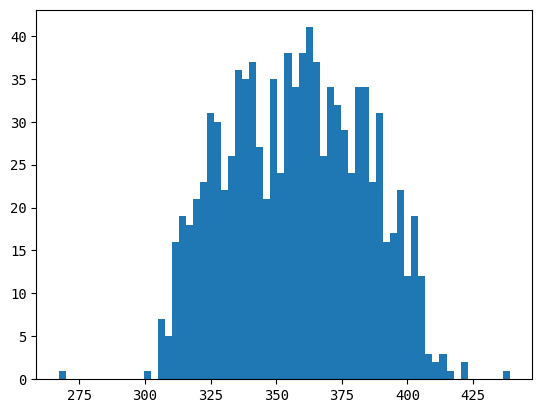

In [6]:
lenth = len(reco)
energies = []

for i in range(1000):
    energies.append(constants["sqrt_s"] - reco["lep1_e"][i] - reco["lep2_e"][i])
    
plt.hist(energies, bins=64)

In [250]:
def generate_masses(data, event_idx, int_variables, evt_constants=constants):
    (mu1E, mu1p), (mu2E, mu2p) = prepare_int(data, event_idx, constants)
    
    rMB1, Thb1, Phb1, ___, Thb1b, Phb1b, rb2, Thb2 = int_variables
    
    j1_4v, j2_4v, j3_4v, j4_4v = get_parton_momenta(data, event_idx)
    
    pIn = np.array([evt_constants["system_E"], evt_constants["system_px"], evt_constants["system_py"], evt_constants["system_pz"]])
    Min = inv_mass(pIn)
    
    MB1min = 2*constants["m_b"]
    MB1max = Min - 2*constants["m_b"]
    MB1 = MB1min*(1-rMB1) + MB1max*rMB1
    
    
    
    ### B1 - in B1 rest frame
    dmB1pow2 = (MB1**2 - 2*constants["m_b"]**2)/2
    
    RhB1bmin = 0
    RhB1bmax = sqrt((dmB1pow2/(constants["m_b"]**2))**2 - constants["m_b"]**2)
    
    print("RhB1bmin", RhB1bmin)
    print("RhB1bmax", RhB1bmax)
    
    RhBb = rMB1*RhB1bmax + (1-rMB1)*RhB1bmin
    print("RhBb:", RhBb)
    
    b1E = sqrt(constants["m_b"]**2 + RhBb**2)
    b1e = unit_vec(Thb1, Phb1)
    b1be = -b1e
    
    b1p = RhBb*b1e
    b1bp = RhBb*b1be
    
    print("b1p:", b1p)
    
    print("pIn", pIn)
    print(inv_mass(pIn))
    print("Min", Min)
    print("MB1", MB1)
    
    print("b1p", b1p)
    print(lorentzBoost(pIn, b1p))

Try 2: Roation in frame aligned to B2
Problem: Calculation of jacobian (?)

In [5]:
from math import acos,asin,copysign,atan2,atan,pi

def inv_mass(v:np.ndarray):
    return sqrt(v[0]**2 - np.dot(v[1:4], v[1:4]))

def get_kinematics_from_int2(int_variables, constants, debug_print=False, epsilon=1e-3, check=False):
    """_summary_

    Args:
        int_variables (_type_): _description_
        constants (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    (mu1E, mu1p), (mu2E, mu2p), rMB1, Thb1, Phb1, rb1, Thb1b, Phb1b, rb2, Thb2 = int_variables
    
    pIn = np.array([constants["sqrt_s"] - mu1E - mu2E, *(-mu1p -mu2p)])
    Min = inv_mass(pIn)
    
    MB1min = 2*constants["m_b"]
    MB1max = Min - 2*constants["m_b"]
    MB1 = MB1min*(1-rMB1) + MB1max*rMB1
    
    print("Min", Min)
    
    dmB1pow2 = (MB1**2 - 2*constants["m_b"]**2)/2
    print("MB1", MB1)
    
    RhB1decEmin = pIn[0] - 3*constants["m_b"]
    Rhb1min = 0
    Rhb1max = min(sqrt((dmB1pow2/(constants["m_b"]**2))**2 - constants["m_b"]**2), RhB1decEmin)
    
    print("RhB1decEmin", RhB1decEmin)
    print("Rhb1min", Rhb1min)
    print("Rhb1max", Rhb1max)
    
    Rhb1 = rb1*Rhb1max + (1-rb1)*Rhb1min
    
    b1E = sqrt(constants["m_b"]**2 + Rhb1**2)
    b1e = unit_vec(Thb1, Phb1)
    b1p = Rhb1*b1e
    
    # Calculate Rhb1b from mB1pow2, Rhb1 and angles
    b1be = unit_vec(Thb1b, Phb1b)
    dot = np.dot(b1e, b1be)
    
    if debug_print:
            print("[REC]")
            print("E_tot:", constants["system_E"])
            print("Rhb1", Rhb1)
    
    if abs(dot) != 1:
        d = (dmB1pow2*Rhb1*dot)/(Rhb1**2*dot**2 - b1E**2)
            
        print((-4*(constants["m_b"]**2) + 4*(dot**2)*constants["m_b"]**2 ))
        print("RhbTresh", sqrt((4*(constants["m_b"]**2)*MB1**2 - MB1**4 )/(-4*(constants["m_b"]**2) + 4*(dot**2)*constants["m_b"]**2 )))
        
        Rhb1b1 = -d + sqrt(((b1E**2)*(constants["m_b"]**2) - dmB1pow2**2)/((Rhb1**2)*(dot**2) - b1E**2) + d**2)
        #Rhb1b2 = -d - sqrt(((b1E**2)*(constants["m_b"]**2) - dmB1pow2**2)/((Rhb1**2)*(dot**2) - b1E**2) + d**2)
    else:
        Rhb1b1 = sqrt((dmB1pow2**2)/(constants["m_b"]**2 + Rhb1**2) - constants["m_b"]**2)
    
    Rhb1b1 = min(Rhb1b1, RhB1decEmin)
    
    if debug_print:
        print("Rhb1b", Rhb1b1)
    
    b1bp1 = Rhb1b1*b1be
    #b1bp2 = Rhb1b2*b1be
    
    b1bE1 = sqrt(constants["m_b"]**2 + Rhb1b1**2)
    #b1bE2 = sqrt(constants["m_b"]**2 + Rhb1b1**2)
    
    # Calculate pH and from that pB2
    pB2 = np.array([
        constants["sqrt_s"] -mu1E -mu2E -(b1E+b1bE1),
        constants["system_px"] -mu1p[0] -mu2p[0] -b1p[0] -b1bp1[0],
        constants["system_py"] -mu1p[1] -mu2p[1] -b1p[1] -b1bp1[1],
        constants["system_pz"] -mu1p[2] -mu2p[2] -b1p[2] -b1bp1[2],
    ])
    
    RhB2 = sqrt(np.dot(pB2[1:4], pB2[1:4]))
    
    if debug_print:
        print("pB2[E,RhB2]:", pB2[0], RhB2)
    
    #Rhb2max = sqrt( (1/(2*pB2[0])*(RhB2**2 + pB2[0]**2))**2 - constants["m_b"]**2 )
    #Rhb2max = sqrt( (pB2[0]-sqrt(Rhb2max**2 + constants["m_b"]**2))**2 - constants["m_b"]**2 )
    
    mB2pow2 = pB2[0]**2 - RhB2**2
    d = 1-(pB2[0]/RhB2)**2
    e = (mB2pow2)/RhB2
    f = (constants["m_b"]*pB2[0]/RhB2)**2 - (mB2pow2**2)/(4*RhB2**2)
    
    Rhb2max1 = -e/(2*d) + sqrt(f/d + (e**2)/(4*d**2))
    Rhb2max2 = -e/(2*d) - sqrt(f/d + (e**2)/(4*d**2))
    
    print("Rhb2max1", Rhb2max1)
    print("Rhb2max2", Rhb2max2)

    Rhb2max = min(Rhb2max1, max(pB2[0]-2*constants["m_b"], 0))
    
    Rhb2min_arg2 = (pB2[0]-sqrt(Rhb2max**2 + constants["m_b"]**2))**2 - constants["m_b"]**2
    if Rhb2min_arg2 < 0:
        if -Rhb2min_arg2 < epsilon:
            Rhb2min_arg2 = 0
        else:
            print("Rhb2min_arg2", Rhb2min_arg2)
            raise Exception("Invalid kinematics")
    Rhb2min = sqrt( Rhb2min_arg2 )
    
    Rhb2 = rb2*Rhb2max + (1-rb2)*Rhb2min
    
    if debug_print:
        print("Rhb2max1:Rhb2max2", Rhb2max1, Rhb2max2)
        print("Rhb2min", Rhb2min)
        print("Rhb2max", Rhb2max)
        print("Rhb2", Rhb2)
        
    if Rhb2max < Rhb2min:
        raise Exception("Invalid kinematics")
    
    if debug_print:
        print("pB2", pB2[0], pB2[1], pB2[2], pB2[3])
    
    # print("pB2", pB2, sqrt(Minkowski(pB2)))
    
    # Calculate Rhb2b
    b2E = sqrt(constants["m_b"]**2 + Rhb2**2)
    b2bE = pB2[0] - b2E
    if b2bE < 0:
        raise Exception("Invalid kinematics")
    
    Rhb2b_arg = b2bE**2 - constants["m_b"]**2
    if Rhb2b_arg < 0:
        if -Rhb2b_arg < epsilon:
            Rhb2b_arg = 0
        else:
            raise Exception("Invalid kinematics")
            
    Rhb2b = sqrt(Rhb2b_arg)
    
    b2p,b2bp = calc_B2_sys(pB2, Rhb2, Rhb2b, PhQ=Thb2, debug_print=debug_print)
    
    if check:
        print("KinCheck")
        pB2int = np.array([b2E+b2bE, *(b2p+b2bp)])
        for i in range(4):
            print(f"Dim[{i}]:", abs(pB2int[i]-pB2[i]))
    
    return (
        (mu1E, *mu1p),
        (mu2E, *mu2p),
        (b1E, *b1p),
        (b1bE1, *b1bp1),
        (b2E, *b2p),
        (b2bE, *b2bp)
    )

In [147]:
#params = [ 0.,          0.,         -3.14159265,  0.,          0.,         -3.14159265,
# 66.66666667,  1.04719755]

params = [ 0.33,  0.00000000e+00, -3.14159265e+00,  0.00000000e+00,
  0.00000000e+00, -3.14159265e+00,  0.50000000e+00,  0.00000000e+00]

get_kinematics_from_int2((*prepare_int(reco, 0, constants), *params), constants, debug_print=True, check=True)

Min 321.7512186572008
MB1 109.44187308925568
RhB1decEmin 330.3175907791754
Rhb1min 0
Rhb1max 258.8890337031703
[REC]
E_tot: 344.71746253967285
Rhb1 0.0
Rhb1b 330.3175907791754
pB2[E,RhB2]: 9.565041442184452 428.53852629900626
Rhb2max1 219.05298431973378
Rhb2max2 209.48554197927248
Rhb2min_arg2 -0.3335623101603531


Exception: Invalid kinematics

In [321]:
angles = []
for i in range(10000):
    angles.append(get_angles(reco["parton1_px"][i], reco["parton1_py"][i], reco["parton1_pz"][i]))

angles = np.array(angles).T

print("Theta: ", angles[0].min(), angles[0].max()) # from 0 to pi
print("Phi: ", angles[1].min(), angles[1].max()) # from -pi to +pi

Theta:  0.020806092217120365 3.129090875493951
Phi:  -3.1406652837567646 3.140991856103514


In [293]:
def f(x):
    if x[0] < 0:
        return 0
    
    return x[0]**3

integ = vegas.Integrator([[-2, 2]])

# step 1 -- adapt to f; discard results
integ(f, nitn=10, neval=10000)

# step 2 -- integ has adapted to f; keep results
result = integ(f, nitn=10, neval=10000)
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   3.999804(54)    3.999804(54)        0.00     1.00
  2   3.999686(57)    3.999749(39)        2.27     0.13
  3   3.999574(58)    3.999695(32)        4.23     0.01
  4   3.999433(62)    3.999639(29)        7.42     0.00
  5   3.999206(63)    3.999565(26)       15.27     0.00
  6   3.998929(66)    3.999478(24)       28.31     0.00
  7   3.998627(68)    3.999380(23)       46.89     0.00
  8   3.998336(67)    3.999271(22)       71.16     0.00
  9   3.998026(69)    3.999161(21)       98.90     0.00
 10   3.997670(70)    3.999041(20)      134.08     0.00

result = 3.999041(20)    Q = 0.00


Integration v1

In [24]:
from analysis.mem_python import int_bf

In [4]:
int_bf(reco, 0)

NameError: name 'int_bf' is not defined

Integration v2

In [5]:
a = int_bf_v2(reco, 0, mode=1, neval=100000, nitn=10)

PS points given:found [4000000:551062] ( 13.78 %)
PS points given:found [1:0] (  0.00 %)
PS points given:found [98304:20266] ( 20.62 %)
PS points given:found [98930:14746] ( 14.91 %)
PS points given:found [99319:28931] ( 29.13 %)
PS points given:found [99395:26762] ( 26.92 %)
PS points given:found [99488:23035] ( 23.15 %)
PS points given:found [99485:40234] ( 40.44 %)
PS points given:found [99459:37663] ( 37.87 %)
PS points given:found [99494:39233] ( 39.43 %)
PS points given:found [99489:32222] ( 32.39 %)
PS points given:found [99463:32956] ( 33.13 %)
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   4.0(2.8)e-16    4.0(2.8)e-16        0.00     1.00
  2   9.4(7.6)e-16    4.6(2.6)e-16        0.45     0.50
  3   2.1(1.8)e-15    5.0(2.6)e-16        0.66     0.51
  4   2.7(1.2)e-15    5.9(2.5)e-16        1.43     0.23
  5   1.9(1.1)e-15    6.5(2.5)e-16        1.41     0.23
  6   4.1(3.6)e-15    6.7(2.5)e-16        1.31   

In [6]:
a = int_bf_v2(reco, 0, mode=0, neval=100000, nitn=10)

PS points given:found [4000000:551365] ( 13.78 %)
PS points given:found [1:0] (  0.00 %)
PS points given:found [98304:21255] ( 21.62 %)
PS points given:found [98803:33914] ( 34.32 %)
PS points given:found [99404:41896] ( 42.15 %)
PS points given:found [99437:40178] ( 40.41 %)
PS points given:found [99498:37528] ( 37.72 %)
PS points given:found [99519:41791] ( 41.99 %)
PS points given:found [99487:44450] ( 44.68 %)
PS points given:found [99437:45239] ( 45.50 %)
PS points given:found [99543:47492] ( 47.71 %)
PS points given:found [99458:48098] ( 48.36 %)
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   1.14(45)e-21    1.14(45)e-21        0.00     1.00
  2   1.7(1.2)e-20    1.16(45)e-21        1.69     0.19
  3   1.5(1.1)e-20    1.19(45)e-21        1.67     0.19
  4   2.0(1.0)e-20    1.22(45)e-21        2.22     0.08
  5   1.9(1.3)e-20    1.24(45)e-21        2.12     0.08
  6   7.6(2.8)e-21    1.40(44)e-21        2.66   

In [7]:
print("asd")

asd


In [10]:
a = int_bf_v2(reco, 28850, mode=1, neval=100000, nitn=10)

PS points given:found [4000000:746007] ( 18.65 %)
PS points given:found [1:0] (  0.00 %)
PS points given:found [98304:21075] ( 21.44 %)
PS points given:found [99473:55565] ( 55.86 %)
PS points given:found [99478:54995] ( 55.28 %)
PS points given:found [99551:61479] ( 61.76 %)
PS points given:found [99542:63430] ( 63.72 %)
PS points given:found [99541:60919] ( 61.20 %)
PS points given:found [99512:62817] ( 63.13 %)
PS points given:found [99511:56579] ( 56.86 %)
PS points given:found [99489:60116] ( 60.42 %)
PS points given:found [99527:62091] ( 62.39 %)
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   4.2(4.2)e-16    4.2(4.2)e-16        0.00     1.00
  2   5.0(2.4)e-18    5.0(2.4)e-18        0.99     0.32
  3   1.54(78)e-16    5.2(2.4)e-18        2.33     0.10
  4   4.9(2.0)e-17    5.8(2.4)e-18        3.16     0.02
  5   8.6(4.4)e-17    6.1(2.4)e-18        3.21     0.01
  6   3.17(98)e-17    7.5(2.3)e-18        3.85   

In [11]:
a = int_bf_v2(reco, 28850, mode=0, neval=100000, nitn=10)

PS points given:found [4000000:746840] ( 18.67 %)
PS points given:found [1:0] (  0.00 %)
PS points given:found [98304:20491] ( 20.84 %)
PS points given:found [99306:41228] ( 41.52 %)
PS points given:found [99489:47427] ( 47.67 %)
PS points given:found [99550:50327] ( 50.55 %)
PS points given:found [99528:56568] ( 56.84 %)
PS points given:found [99519:63562] ( 63.87 %)
PS points given:found [99520:67768] ( 68.09 %)
PS points given:found [99525:71034] ( 71.37 %)
PS points given:found [99481:73300] ( 73.68 %)
PS points given:found [99533:78271] ( 78.64 %)
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   9.2(7.7)e-23    9.2(7.7)e-23        0.00     1.00
  2   9.8(3.1)e-23    9.7(2.9)e-23        0.01     0.94
  3   3.3(2.5)e-21    9.7(2.9)e-23        0.79     0.46
  4   1.50(48)e-22    1.11(25)e-22        0.82     0.48
  5   2.11(71)e-22    1.22(23)e-22        1.05     0.38
  6   3.44(99)e-22    1.34(23)e-22        1.79   

In [12]:
a = int_bf_v2(reco, 28850, mode=0, neval=1000000, nitn=10)

PS points given:found [4000000:746619] ( 18.67 %)
PS points given:found [1:0] (  0.00 %)
PS points given:found [800000:166242] ( 20.78 %)
PS points given:found [100000:20501] ( 20.50 %)
PS points given:found [947156:586189] ( 61.89 %)
PS points given:found [25940:5526] ( 21.30 %)
PS points given:found [949532:608153] ( 64.05 %)
PS points given:found [25127:5376] ( 21.40 %)
PS points given:found [949027:642300] ( 67.68 %)
PS points given:found [25826:5975] ( 23.14 %)
PS points given:found [949781:687681] ( 72.40 %)
PS points given:found [25027:5908] ( 23.61 %)
PS points given:found [949866:745276] ( 78.46 %)
PS points given:found [25011:6201] ( 24.79 %)
PS points given:found [949687:752395] ( 79.23 %)
PS points given:found [25079:6552] ( 26.13 %)
PS points given:found [949654:761818] ( 80.22 %)
PS points given:found [25029:6854] ( 27.38 %)
PS points given:found [949551:773608] ( 81.47 %)
PS points given:found [25055:7274] ( 29.03 %)
PS points given:found [949484:774923] ( 81.62 %)
PS po

In [54]:
event_idx = 28820
print(calc_zhh(get_kinematics(mcp, True, event_idx))[0]/calc_zzh(get_kinematics(mcp, True, event_idx))[0])

549927.2896141493


In [35]:
print(calc_zhh(get_kinematics(mcp, True, 0)), calc_zzh(get_kinematics(mcp, True, 0)))

[9.022629884234561e-08] [6.847052227345311e-13]


In [7]:
print(len(reco))

28939


In [33]:
length = 64

zhh_indices = np.argwhere(reco["is_zhh"] == True).flatten()
zzh_indices = np.argwhere(reco["is_zzh"] == True).flatten()

a = np.random.choice(zhh_indices, length, replace=False)
b = np.random.choice(zzh_indices, length, replace=False)

for i in range(len(a)):
    print(a[i])
    print(b[i])

10630
23989
20323
25634
1844
25237
19288
24491
18969
26180
16308
26379
16443
23903
21492
22788
993
25061
11424
24971
3737
26414
14125
27112
9568
23077
16845
23592
9201
27155
19341
22800
12261
24903
15863
26108
12156
24362
5640
23427
5529
27448
19180
23815
13053
28366
6886
27446
17634
26160
16339
27086
4078
24073
3000
27231
1131
25009
13791
23886
19857
22627
17970
27246
2821
23756
517
22945
18833
25366
21540
24210
6442
26062
1242
25816
13576
25776
12867
27810
18788
28903
9643
23205
5437
24395
11634
25352
7987
26215
16742
28360
16373
27140
9264
23948
16535
23575
12698
28214
14184
24989
19084
23234
21238
24698
20127
24155
19031
27934
17034
26807
21299
26294
14787
26789
3484
26010
11155
28863
12670
24313
10861
22565
6325
24219
19078
25557


array([28199, 24443, 26193, 23998, 23775, 26247, 22643, 27258, 23008,
       23895, 26137, 28226, 24186, 22663, 24306, 27691, 22993, 26367,
       24497, 26816, 26711, 28196, 28124, 23266, 27766, 26246, 25544,
       28133, 28506, 25118, 28722, 23457, 22983, 26126, 22829, 22790,
       22892, 27160, 28231, 26673, 25475, 26748, 24929, 26424, 23177,
       24520, 26312, 28791, 26003, 23446, 22727, 22582, 25864, 27736,
       26563, 26559, 25287, 24431, 28418, 24068, 26048, 23913, 26204,
       28895])

In [6]:
int_bf_v2(reco, 0, mode=1, neval=2000000, precond_size=4000000, nitn=10)

PS points given:found [4000000:550673] ( 13.77 %)
PS points given:found [1:0] (  0.00 %)
PS points given:found [900000:234158] ( 26.02 %)
PS points given:found [900000:236730] ( 26.30 %)
PS points given:found [967112:598794] ( 61.92 %)
PS points given:found [931414:597061] ( 64.10 %)
PS points given:found [1218981:861208] ( 70.65 %)
PS points given:found [680835:443340] ( 65.12 %)
PS points given:found [1157170:728898] ( 62.99 %)
PS points given:found [742679:518751] ( 69.85 %)
PS points given:found [719317:475416] ( 66.09 %)
PS points given:found [1180575:828665] ( 70.19 %)
PS points given:found [470581:280829] ( 59.68 %)
PS points given:found [1429252:1064541] ( 74.48 %)
PS points given:found [1160336:700049] ( 60.33 %)
PS points given:found [739437:524844] ( 70.98 %)
PS points given:found [1340972:1043423] ( 77.81 %)
PS points given:found [558780:347245] ( 62.14 %)
PS points given:found [633448:425052] ( 67.10 %)
PS points given:found [1266308:776785] ( 61.34 %)
PS points given:foun

In [7]:
int_bf_v2(reco, 0, mode=1, neval=10000000, precond_size=4000000, nitn=10)

PS points given:found [4000000:551621] ( 13.79 %)
PS points given:found [1:0] (  0.00 %)
PS points given:found [800000:181349] ( 22.67 %)
PS points given:found [800000:208084] ( 26.01 %)
PS points given:found [800000:215816] ( 26.98 %)
PS points given:found [800000:212496] ( 26.56 %)
PS points given:found [800000:185290] ( 23.16 %)
PS points given:found [500000:102445] ( 20.49 %)
PS points given:found [657348:372534] ( 56.67 %)
PS points given:found [1568952:617902] ( 39.38 %)
PS points given:found [318363:126208] ( 39.64 %)
PS points given:found [929138:428420] ( 46.11 %)
PS points given:found [554435:348490] ( 62.85 %)
PS points given:found [229444:83776] ( 36.51 %)
PS points given:found [1388425:1017706] ( 73.30 %)
PS points given:found [1736343:1324656] ( 76.29 %)
PS points given:found [989279:719791] ( 72.76 %)
PS points given:found [372042:186631] ( 50.16 %)
PS points given:found [254177:90139] ( 35.46 %)
PS points given:found [134260:32141] ( 23.94 %)
PS points given:found [1433

In [8]:
from analysis.mem import int_bf_v2

In [6]:
int_bf_v2(reco, 0)

PS points 1000000 points : Found 137557 ( 13.76 %)
PS points 1 points : Found 0 (  0.00 %)
PS points 800000 points : Found 170039 ( 21.25 %)
PS points 800000 points : Found 199875 ( 24.98 %)
PS points 800000 points : Found 207795 ( 25.97 %)
PS points 800000 points : Found 201910 ( 25.24 %)
PS points 800000 points : Found 175793 ( 21.97 %)
PS points 500000 points : Found 95677 ( 19.14 %)
PS points 474487 points : Found 209333 ( 44.12 %)
PS points 1090145 points : Found 631050 ( 57.89 %)
PS points 508950 points : Found 295234 ( 58.01 %)
PS points 257624 points : Found 85111 ( 33.04 %)
PS points 1490396 points : Found 786022 ( 52.74 %)
PS points 134847 points : Found 26827 ( 19.89 %)
PS points 267683 points : Found 86468 ( 32.30 %)
PS points 3098526 points : Found 2587279 ( 83.50 %)
PS points 458237 points : Found 277901 ( 60.65 %)
PS points 211612 points : Found 60926 ( 28.79 %)
PS points 586879 points : Found 355110 ( 60.51 %)
PS points 125092 points : Found 24893 ( 19.90 %)
PS points 4

In [7]:
int_bf_v2(reco, 0, mode=0)

PS points 1000000 points : Found 138022 ( 13.80 %)
PS points 1 points : Found 0 (  0.00 %)
PS points 800000 points : Found 192053 ( 24.01 %)
PS points 800000 points : Found 225090 ( 28.14 %)
PS points 800000 points : Found 230511 ( 28.81 %)
PS points 800000 points : Found 228094 ( 28.51 %)
PS points 800000 points : Found 198979 ( 24.87 %)
PS points 500000 points : Found 109104 ( 21.82 %)
PS points 756917 points : Found 422643 ( 55.84 %)
PS points 1162244 points : Found 819575 ( 70.52 %)
PS points 1445046 points : Found 1095506 ( 75.81 %)
PS points 412684 points : Found 139751 ( 33.86 %)
PS points 379484 points : Found 164856 ( 43.44 %)
PS points 137837 points : Found 32846 ( 23.83 %)
PS points 625060 points : Found 246862 ( 39.49 %)
PS points 1753068 points : Found 1358407 ( 77.49 %)
PS points 544942 points : Found 392015 ( 71.94 %)
PS points 235420 points : Found 84606 ( 35.94 %)
PS points 1579585 points : Found 1026099 ( 64.96 %)
PS points 136455 points : Found 36851 ( 27.01 %)
PS po

In [7]:
from analysis.mem_python import int_test_bf

corr, fail, kins, errors, inputs = int_test_bf(reco, 0)
print("Valid:Fail", corr, fail)

[array([15575.04      , 15608.37333333, 15641.70666667, 15675.04      ]), array([0.        , 1.04719755, 2.0943951 , 3.14159265]), array([-3.14159265, -1.04719755,  1.04719755,  3.14159265]), array([  0.        ,  66.66666667, 133.33333333, 200.        ]), array([0.        , 1.04719755, 2.0943951 , 3.14159265]), array([-3.14159265, -1.04719755,  1.04719755,  3.14159265]), array([  0.        ,  66.66666667, 133.33333333, 200.        ]), array([0.        , 1.04719755, 2.0943951 , 3.14159265])]
Done
Valid:Fail 1413 64123


In [352]:
inputs[0]

array([ 1.55750400e+04,  0.00000000e+00, -3.14159265e+00,  6.66666667e+01,
        2.09439510e+00, -3.14159265e+00,  6.66666667e+01,  2.09439510e+00])

In [429]:
integrand = construct_integrand_bf(reco, 0, constants)

In [430]:
integrand(inputs[0])

Found valid phase space point


8.635565289460913e-18

In [303]:
kin_idx = 0

print("E_tot:", np.sum(valid[kin_idx].T[0]))

for i in range(len(valid[kin_idx])):
    vec = valid[kin_idx][i]
    print(inv_mass(vec))

E_tot: 344.71746253967285
4.799957253499271
4.799957253499271
4.799957253499366
4.799957253498893


## Validate get_kinematics_from_int against MC Particle data

In [227]:
def get_values_true(data, event_idx, constants=constants):
    energies, momenta, angles = get_kinematics_tf(data, event_idx, 0)
    
    #print("[TRUE]")
    #print("energies:", energies)
    #print("momenta:", momenta)
    #print("angles:", angles)
    
    mB1pow2 = 125.**2
    
    Thb1 = angles[2][0]
    Phb1 = angles[2][1]
    Rhb1 = momenta[2]
    
    Thb1b = angles[3][0]
    Phb1b = angles[3][1]
    
    Rhb2 = momenta[4]
    Thb2 = angles[4][0]
    
    return mB1pow2, Thb1, Phb1, Rhb1, Thb1b, Phb1b, Rhb2, Thb2

In [232]:
good = []
bad  = []
err  = []

for i in tqdm(range(18000)):
    event_idx = i

    muon_kin = prepare_int(reco, event_idx, constants, False)
    values = get_values_true(reco, event_idx, constants)

    evt_constants = constants | get_corrections(reco, event_idx, 0)

    #print("[REC]")
    result = get_kinematics_from_int(
        (*muon_kin, *values), evt_constants, return_p_in=True
    )

    if isinstance(result, tuple):
        pIn, kin = result

        check = np.array([
            pIn[0] - np.sum(kin.T[0]),
            pIn[1] - np.sum(kin.T[1]),
            pIn[2] - np.sum(kin.T[2]),
            pIn[3] - np.sum(kin.T[3])
        ])
        
        dEmax = 1.
        dpmax = 1.
        
        dE = check[0]
        dp = sqrt(check[1]**2 + check[2]**2 + check[3]**2)
        
        #print("sumX:", np.sum(kin.T[1]) - evt_constants["system_px"])
        #print("sumY:", np.sum(kin.T[2]) - evt_constants["system_py"])
        #print("sumZ:", np.sum(kin.T[3]) - evt_constants["system_pz"])
        #print(kin)
        
        if dE < dEmax and dp < dpmax:
            good.append(i)
        else:
            bad.append(i)
            err.append((dE, dp))
        
        #print("dE:dp", dE, dp)
        #print("E_tot:", np.sum(result[0].T[0]))
        #print("[TRUE]")
        #print(get_all_momenta(reco, event_idx, True, False))
    else:
        bad.append(i)
        err.append(result)

print("Good:", len(good), "Bad:", len(bad))

  0%|          | 0/18000 [00:00<?, ?it/s]

100%|██████████| 18000/18000 [00:12<00:00, 1461.93it/s]

Good: 17999 Bad: 1


In [230]:
bad, err

[14069]

In [ ]:
import vegas, math

def int_brute_force():
    
    
    

In [212]:
from itertools import product

def int_test(event_idx, samples_per_dim=4, evt_constants=constants, use_reco=True):
    Rhb1max = 200
    
    muon_kin = prepare_int(reco, event_idx, evt_constants, use_reco)
    ((mu1E, mu1p), (mu2E, mu2p)) = muon_kin
    
    mB2max = sqrt(constants["sqrt_s"] - mu1E -mu2E -2*constants["m_b"]**2)
    
    print("Rhb1max", Rhb1max)
    
    boundaries = [
        (60**2, 130**2), # mB1pow2
        (0., pi), # Thb1
        
        (-pi, pi), # Phb1
        (0., Rhb1max), # Rhb1
        
        (0., pi), # Thb1b
        (-pi, pi), # Phb1b
        
        (0., 1.), # rb2
        (0., pi) # Thb2
    ]

    samples = []
    for boundary in boundaries:
        samples.append(np.linspace(boundary[0], boundary[1], samples_per_dim))
        
    print(samples)
    
    # results in 8**samples_per_dim evaluations; for start 8**4=2**12=4096 evaluations
    
    values = np.zeros(8)
    
    corr = 0
    fail = 0
    
    for i in product(range(samples_per_dim), repeat=8):
        for j in range(8):
            values[j] = samples[j][i[j]]
        
        # evaluate
        # arg order: (mu1E, mu1p), (mu2E, mu2p), mB1pow2, Thb1, Phb1, Rhb1, Thb1b, Phb1b, Rhb2, Thb2 = int_variables
        try:
            kin = np.array(get_kinematics_from_int2(
                (*muon_kin, *values), evt_constants, debug_print=False
            ))
            corr += 1
        except Exception:
            print(f"Exception occured with params=", values, "at i=", i)
            fail += 1
    
    print("Done")
    
    return corr, fail

[-0.01228369  0.01028771  0.07260984 -0.00869742  2.85161099]
[-0.01201151  0.01533804  0.09830353  0.00845462  3.14644638]


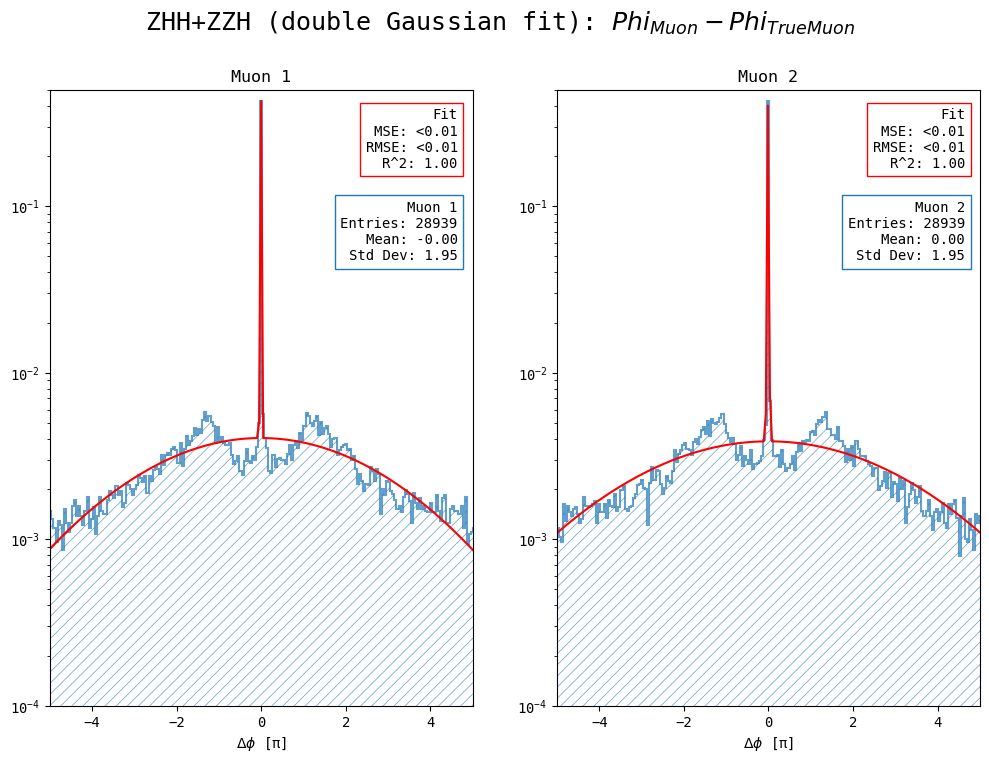

In [114]:
dg = []
fit_init = []
for i in range(2):
    dg.append((df[i][1]["lep"], df[i][1]["true_lep"]))
    fit_init.append([0, 0.1, 0.08, 0, 0.8])

plot_transfer(dg, "ZHH+ZZH (double Gaussian fit)", fit="dbgauss_old", quantity="Phi", xlabel=r"$\Delta\phi$ [π]", true_label="True Muon", reco_label="Muon", fit_init=fit_init, xlim=(-5,5), ylim=(0.0001, 0.5), n_bins=256, yscale="log")